# Neural machine translation with a Transformer and Keras

## Overview 🚀

This notebook offers a hands-on tutorial for building a neural machine translation model using the Transformer architecture with Keras and TensorFlow.

You'll be guided through:
- 📦 Preparing and tokenizing a Portuguese-English translation dataset.
- 🏗️ Constructing essential model components, including positional embeddings and attention layers.
- 🧩 Assembling a multi-layer Transformer encoder-decoder model.

By the end, you will:
- 🏋️‍♂️ Train the model.
- 🌍 Generate translations.
- 🔍 Visualize attention mechanisms.

Complex concepts are broken down into clear, manageable steps, making this notebook accessible for anyone interested in state-of-the-art sequence-to-sequence models for natural language processing tasks.


## Goal 🎯

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). 🌍🔄

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). 🤖✨ Self-attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest! The goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- 📦 Prepare the data.
- 🏗️ Implement necessary components:
  - 🧩 Positional embeddings.
  - 🎯 Attention layers.
  - 🏛️ The encoder and decoder.
- 🤖 Build & train the Transformer.
- 🌍 Generate translations.
- 📦 Export the model.

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in layer 1 that used in the gradient recurrent (GRU) NMT model. 🤖🔄

A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self-attention layers. ✨
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex. 🚀

Self--attentionattention layers and RNN layers layers differ differ in:

1. **Parallelism**:
    - **Self-Attention**: Processes tokens all in tokens a in sequence a simultaneously, allowing sequence for simultaneously, parallel allowin
    - **RNN**: Processes tokens sequentially, one step at a time, which limits parallelism and makes

2. **Context**:
    - **Self-Attention**: Allows each token to attend to all other
    - **RNN**: Captures context incrementally, with information flowing step-by

3. **Gradient Flow**:
    - **Self-
    - **RNN**: Suffers from vanishing/exploding gradients over long sequences, making training more challenging.

4. **Receptive Field**:
    - **Self-Attention**: Has a global receptive field, meaning every token can directly interact with every other token.
    - **RNN**: Has a limited receptive field, as information must propagate through intermediate steps.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant 🤖✨

- Transformers excel at modeling sequential data, such as natural language. 🗣️
- Unlike [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. ⚡ The main reason is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (such as [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. 🔗 Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)). 🕹️

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [1]:
# # Install a specific version of CUDA's cuDNN library required for TensorFlow GPU support.
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

# Uninstall any existing versions of TensorFlow, Keras, TensorFlow Estimator, and TensorFlow Text
# to avoid conflicts and ensure a clean environment.
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text

# Install a compatible version of protobuf, which is required by TensorFlow and TensorFlow Datasets.
!pip install protobuf~=3.20.3

# Install TensorFlow Datasets for easy access to pre-built datasets.
!pip install -q tensorflow_datasets

# Install or upgrade TensorFlow and TensorFlow Text to the latest versions.
# TensorFlow Text provides text processing ops compatible with TensorFlow.
!pip install -q -U tensorflow-text tensorflow

!pip install matplotlib
!pip install wrapt==1.15.0
!export WRAPT_DISABLE_EXTENSIONS=true

  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


Import the necessary modules:

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text
import wrapt
if wrapt.__version__!="1.15.0" or tf.__version__!="2.19.1":
  raise Exception(f"Please restart your session as you are still using warpt version: {wrapt.__version__} and tensorflow: {tf.__version__}")

2025-10-13 05:11:48.863768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 05:11:48.883841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760332308.906730 3514567 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760332308.914350 3514567 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760332308.932250 3514567 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data handling 📦

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [3]:
# Load the TED Talks Portuguese-English translation dataset using TensorFlow Datasets.
# 'with_info=True' returns the dataset and its metadata (such as feature info, splits, etc.).
# 'as_supervised=True' returns each example as a tuple (input, target) instead of a dictionary.

examples, metadata = tfds.load(
    'ted_hrlr_translate/pt_to_en',  # Dataset name: TED Talks Portuguese to English
    with_info=True,                 # Also return metadata about the dataset
    as_supervised=True              # Return examples as (input, target) pairs
)

# Split the loaded dataset into training and validation sets.
train_examples = examples['train']        # Training set: used to train the model
val_examples = examples['validation']     # Validation set: used to evaluate model performance during training

2025-10-13 05:11:51.799588: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [4]:
# Iterate over a single batch of 3 examples from the training dataset.
for pt_examples, en_examples in train_examples.batch(3).take(1):
  # Print the Portuguese examples in the batch.
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    # Decode the byte string to a regular string for display.
    print(pt.decode('utf-8'))
  print()

  # Print the corresponding English examples in the batch.
  print('> Examples in English:')
  for en in en_examples.numpy():
    # Decode the byte string to a regular string for display.
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2025-10-13 05:11:52.017459: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-13 05:11:52.024636: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-13 05:11:52.025020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Set up the tokenizer 🧩

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation). ✂️🔢

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. 🧩 To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format. 🧩🔤

> Note: This is different from the [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.

Download, extract, and import the `saved_model`: 📦⬇️

In [5]:
import os

# Define the directory where artifacts (such as downloaded models) will be stored.
SAVE_DIR = 'artifacts/.'

# If the directory does not exist, create it.
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Name of the tokenizer model to download.
model_name = 'ted_hrlr_translate_pt_en_converter'

# Download the tokenizer model zip file from TensorFlow's public storage.
# tf.keras.utils.get_file will:
#   - Download the file if it does not exist in the cache.
#   - Store it in the specified cache_dir and cache_subdir.
#   - Extract the contents of the zip file after downloading.
tf.keras.utils.get_file(
    f'{model_name}.zip',  # Name for the downloaded file.
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',  # URL to download from.
    cache_dir=SAVE_DIR,   # Directory to cache the file.
    cache_subdir='.',     # Subdirectory within the cache directory.
    extract=True          # Automatically extract the zip file after download.
)

'artifacts/././ted_hrlr_translate_pt_en_converter_extracted'

In [6]:
# Construct the path to the tokenizer SavedModel directory.
# The tokenizer was downloaded and extracted in the previous cell.
# SAVE_DIR: Directory where artifacts are stored (created earlier).
# model_name: Name of the tokenizer model (set earlier).
# The "_extracted" subdirectory is created by tf.keras.utils.get_file(extract=True).
TOKENIZER_PATH = os.path.join(SAVE_DIR, f"{model_name}_extracted", model_name)

# Load the tokenizer SavedModel from the constructed path.
# This loads a TensorFlow SavedModel containing two tokenizers:
#   - tokenizers.pt: Portuguese tokenizer
#   - tokenizers.en: English tokenizer
# Each tokenizer provides methods for tokenization, detokenization, and vocabulary lookup.
tokenizers = tf.saved_model.load(TOKENIZER_PATH)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

This code lists all the public attributes and methods of the `tokenizers.en` object, filtering out private or internal attributes (those starting with `_`). It helps you explore the available functionality of the English tokenizer.

In [7]:
# List all public attributes and methods of the English tokenizer object.
# The dir() function returns all attributes (including methods) of an object.
# The list comprehension filters out any attribute names that start with an underscore ('_'),
# which are typically private or internal attributes in Python.
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [8]:
# Print a batch of English strings from the dataset.
print('> This is a batch of strings from the first batch of examples:')
for en in en_examples.numpy():
  # Each element in en_examples is a byte string, so decode it to a regular string for display.
  print(en.decode('utf-8'))

> This is a batch of strings from the first batch of examples:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [9]:
# Tokenize a batch of English examples using the loaded tokenizer.
# This converts each string in en_examples to a sequence of token IDs.
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
# Iterate through each row (example) in the tokenized batch.
for row in encoded.to_list():
  # Print the list of token IDs for each example.
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


2025-10-13 05:11:53.127255: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


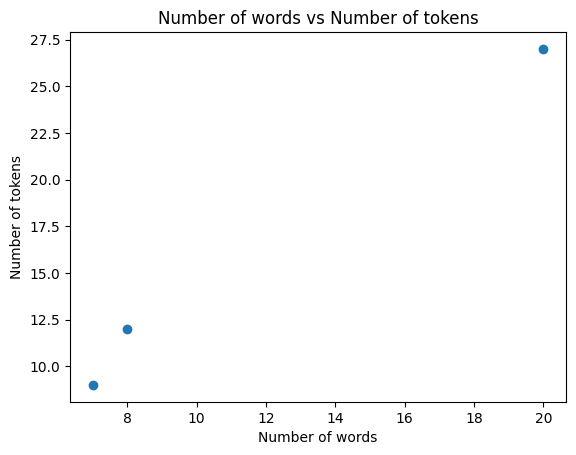

<Figure size 640x480 with 0 Axes>

In [10]:
# list of number of token IDs per example in the batch
num_tokens = [len(row) for row in encoded.to_list()]
# list of number of words/punctuation per example in the batch
num_words = [len(en.decode('utf-8').split()) for en in en_examples.numpy()]

# scatter plot of number of words vs number of tokens
plt.scatter(num_words, num_tokens)
plt.xlabel('Number of words')
plt.ylabel('Number of tokens')
plt.title('Number of words vs Number of tokens')
plt.show() 
plt.savefig('assets/words_vs_tokens.png')

In [11]:
# iterate through en to find the example with 20 words
for i, en in enumerate(en_examples.numpy()):
    if len(en.decode('utf-8').split()) == 20:
        print(f'Found example with 20 words at index {i}:')
        print(en.decode('utf-8'))
        # print its list of token IDs
        print('Token IDs:', encoded[i])
        break


Found example with 20 words at index 0:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
Token IDs: tf.Tensor(
[   2   72  117   79 1259 1491 2362   13   79  150  184  311   71  103
 2308   74 2679   13  148   80   55 4840 1434 2423  540   15    3], shape=(27,), dtype=int64)


In [12]:
# Fix for the TensorFlow string tensor error
# Convert string to tf.Tensor before passing to tokenizer

# Your original string
sentence = 'e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .'

print(f"Original sentence: {sentence}")
print(f"Type: {type(sentence)}")

# Method 1: Convert to tf.constant (recommended)
sentence_tensor = tf.constant(sentence)
print(f"\nAfter tf.constant conversion:")
print(f"Type: {type(sentence_tensor)}")
print(f"Dtype: {sentence_tensor.dtype}")

# Now this should work:
try:
    tokenized = tokenizers.pt.tokenize(sentence_tensor)
    print(f"\nTokenization successful!")
    print(f"Tokenized shape: {tokenized.shape}")
    print(f"First 10 tokens: {tokenized[:10]}")
except Exception as e:
    print(f"Error: {e}")

# Method 2: For batch processing, wrap in tf.constant
sentences = [
    'e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .',
    'esta é uma frase de teste .',
    'olá mundo !'
]

print(f"\n--- Batch Processing ---")
sentences_tensor = tf.constant(sentences)
print(f"Batch tensor shape: {sentences_tensor.shape}")
print(f"Batch tensor dtype: {sentences_tensor.dtype}")

try:
    batch_tokenized = tokenizers.pt.tokenize(sentences_tensor)
    print(f"Batch tokenization successful!")
    print(f"Batch tokenized shape: {batch_tokenized.shape}")
except Exception as e:
    print(f"Batch error: {e}")

Original sentence: e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
Type: <class 'str'>

After tf.constant conversion:
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Dtype: <dtype: 'string'>
Error: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'strings:0' shape=() dtype=string>
  Keyword arguments: {}

 Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='strings')
  Keyword arguments: {}

--- Batch Processing ---
Batch tensor shape: (3,)
Batch tensor dtype: <dtype: 'string'>


Batch tokenization successful!
Batch tokenized shape: (3, None)


The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [13]:
# Detokenize the batch of token IDs back into human-readable text.
# 'encoded' is a batch of token IDs produced by the tokenizer.
# 'tokenizers.en.detokenize' converts these token IDs back to strings.
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
# Iterate through each detokenized string in the batch.
for line in round_trip.numpy():
  # Each line is a byte string, so decode it to a regular string for display.
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [14]:
# Print a header to indicate what is being displayed.
print('> This is the text split into tokens:')

# Use the English tokenizer's 'lookup' method to convert token IDs (from 'encoded')
# back into their corresponding token strings. This returns a RaggedTensor of tokens.
tokens = tokenizers.en.lookup(encoded)

# Display the resulting tokens. Each example in the batch is shown as a list of tokens.
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [15]:
# Initialize an empty list to store the lengths of tokenized sequences.
lengths = []

# Iterate over the training examples in batches of 1024.
for pt_examples, en_examples in train_examples.batch(1024):
  # Tokenize the batch of Portuguese examples using the pretrained tokenizer.
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  # Append the lengths of each tokenized Portuguese sequence in the batch to the 'lengths' list.
  lengths.append(pt_tokens.row_lengths())

  # Tokenize the batch of English examples using the pretrained tokenizer.
  en_tokens = tokenizers.en.tokenize(en_examples)
  # Append the lengths of each tokenized English sequence in the batch to the 'lengths' list.
  lengths.append(en_tokens.row_lengths())

  # Print a dot for each batch processed, to indicate progress.
  print('.', end='', flush=True)

...................................................

2025-10-13 05:11:58.130236: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


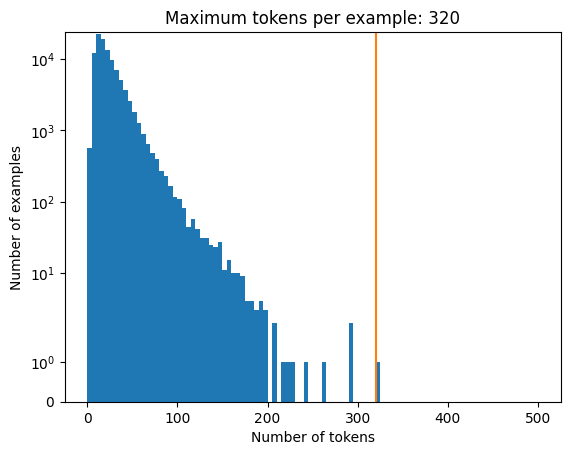

In [16]:
# Concatenate all tokenized sequence lengths from the 'lengths' list into a single numpy array.
all_lengths = np.concatenate(lengths)

# Plot a histogram of the token counts per example.
# The bins are set from 0 to 500, with 101 intervals.
plt.hist(all_lengths, np.linspace(0, 500, 101))

# Set the y-axis limits to the current limits (this line is redundant but preserves the current view).
plt.ylim(plt.ylim())

# Find the maximum token count in the dataset.
max_length = max(all_lengths)

# Draw a vertical line at the maximum token count to highlight it on the histogram.
plt.plot([max_length, max_length], plt.ylim())

# Add a title to the plot showing the maximum number of tokens per example.
plt.title(f'Maximum tokens per example: {max_length}');
# log scale for y axis
plt.yscale('symlog') 
plt.xlabel('Number of tokens')
plt.ylabel('Number of examples')
plt.savefig('assets/max_tokens_per_example.png')

In [17]:
# Identify token counts that have negative number of examples.
num_zero_or_negative = np.sum(all_lengths <= 0)
print(f"Number of token counts with zero or negative examples: {num_zero_or_negative}")

Number of token counts with zero or negative examples: 0


### Set up a data pipeline with `tf.data` 📊🔄

The following function takes batches of text as input, and converts them to a format suitable for training. 📝➡️🤖

1. It tokenizes them into ragged batches. ✂️
2. It trims each to be no longer than `MAX_TOKENS`. ✂️🔢
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token. 🔄
4. It converts the `RaggedTensor`s to padded dense `Tensor`s. 🧩
5. It returns an `(inputs, labels)` pair. 🎯


In [18]:
# Set the maximum number of tokens for input and output sequences.
MAX_TOKENS = 128

def prepare_batch(pt, en):
    # Tokenize the batch of Portuguese sentences.
    # Output is a RaggedTensor of token IDs.
    pt = tokenizers.pt.tokenize(pt)
    # Trim each Portuguese sequence to a maximum of MAX_TOKENS tokens.
    pt = pt[:, :MAX_TOKENS]
    # Convert the RaggedTensor to a dense Tensor, padding with zeros as needed.
    pt = pt.to_tensor()

    # Tokenize the batch of English sentences.
    en = tokenizers.en.tokenize(en)
    # Trim each English sequence to a maximum of MAX_TOKENS+1 tokens.
    # The extra token is for shifting during input/label creation.
    en = en[:, :(MAX_TOKENS + 1)]
    # Prepare the decoder input by removing the last token ([END]).
    en_inputs = en[:, :-1].to_tensor()
    # Prepare the decoder labels by removing the first token ([START]).
    en_labels = en[:, 1:].to_tensor()

    # Return a tuple: ((Portuguese tokens, English input tokens), English label tokens)
    # This matches the expected input format for training a sequence-to-sequence model.
    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 📝➡️📦

1. It tokenizes the text, and filters out the sequences that are too long. ✂️
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once. 🗃️
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 🔀
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. ⚡ See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [19]:
# Set the buffer size for shuffling the dataset.
# A larger buffer size means better shuffling, but uses more memory.
BUFFER_SIZE = 20000

# Set the batch size for training.
# This determines how many examples are processed together in one training step.
BATCH_SIZE = 64

In [20]:
def make_batches(ds):
  # Shuffle the dataset with a buffer size for randomness.
  # This helps ensure that batches are not correlated and improves training.
  return (
      ds
      .shuffle(BUFFER_SIZE)  # Randomly shuffle the dataset using the specified buffer size.
      .batch(BATCH_SIZE)     # Group the dataset into batches of size BATCH_SIZE.
      # Map the prepare_batch function to each batch.
      # prepare_batch tokenizes, trims, and formats the data for training.
      .map(prepare_batch, tf.data.AUTOTUNE)
      # Prefetch allows data loading and processing to happen asynchronously,
      # so the model always has data ready for training, improving performance.
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )

## Test the Dataset 🧪✨

In [21]:
# Create training and validation set batches for the Transformer model.
#
# The make_batches function:
#   - Shuffles the dataset for randomness (improves training).
#   - Batches the data into groups of BATCH_SIZE examples.
#   - Tokenizes and formats each batch using prepare_batch (converts text to token IDs, trims, splits, pads).
#   - Prefetches batches for efficient input pipeline (overlaps data preparation and model execution).
#
# train_batches: tf.data.Dataset of (inputs, labels) pairs for training.
# val_batches: tf.data.Dataset of (inputs, labels) pairs for validation.
# Each 'inputs' is a tuple of (Portuguese tokens, English input tokens).
# Each 'labels' is the English target tokens, shifted by one position for teacher forcing.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [22]:
# save english examples

The resulting `tf.data.Dataset` objects are setup for training with Keras.  
Keras `Model.fit` training expects `(inputs, labels)` pairs.  
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.  
The `labels` are the same English sequences shifted by 1.  
This shift is so that at each location input `en` sequence, the `label` in the next token.  

🧑‍💻➡️🤖


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb) ✍️,
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on. 🌐➡️🇬🇧

This setup is called "teacher forcing" 👨‍🏫 because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model. ⚡
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel. 🏃‍♂️🏃‍♀️

You might have expected the `input, output`, pairs to simply be the `Portuguese, English` sequences. 🇵🇹➡️🇬🇧
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input. 🔄
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right), 🐢
but it can give a more stable model because the model has to learn to correct its own errors during training. 🛠️

In [23]:
# Iterate over one batch from the training dataset.
# train_batches yields ((pt, en), en_labels) for each batch:
#   - pt: Portuguese token IDs, shape (batch_size, seq_len)
#   - en: English input token IDs, shape (batch_size, seq_len)
#   - en_labels: English target token IDs, shape (batch_size, seq_len)
for (pt, en), en_labels in train_batches.take(1):
  # 'break' is used to exit after the first batch is retrieved.
  break

# Print the shapes of the token tensors in the batch.
# These shapes help verify the batch dimensions and sequence lengths.
print(pt.shape)        # Shape of Portuguese token batch (batch_size, seq_len)
print(en.shape)        # Shape of English input token batch (batch_size, seq_len)
print(en_labels.shape) # Shape of English label token batch (batch_size, seq_len)

(64, 56)
(64, 47)
(64, 47)


The `en` and `en_labels` are the same, just shifted by 1:

In [24]:
# Print the first 10 token IDs from the first example in the English input batch.
# 'en' contains the input token IDs for the decoder (English), shape: (batch_size, seq_len).
print(en[0][:10])

# Print the first 10 token IDs from the first example in the English label batch.
# 'en_labels' contains the target token IDs for the decoder (English), shape: (batch_size, seq_len).
# These are shifted by one position compared to 'en', so each label is the next token for each input position.
print(en_labels[0][:10])

tf.Tensor([  2 904  75 196  50   9  56 195 123 157], shape=(10,), dtype=int64)
tf.Tensor([904  75 196  50   9  56 195 123 157  85], shape=(10,), dtype=int64)


In [25]:
# Vocabulary analysis for Portuguese and English tokenizers
# Get the size of the Portuguese tokenizer vocabulary.
pt_vocab_size = tokenizers.pt.get_vocab_size().numpy()
print(f'Portuguese vocabulary size: {pt_vocab_size}')
# Get the size of the English tokenizer vocabulary.
en_vocab_size = tokenizers.en.get_vocab_size().numpy()
print(f'English vocabulary size: {en_vocab_size}')

Portuguese vocabulary size: 7765
English vocabulary size: 7010


Analyzing sequence lengths in training dataset...
....................................................
Processed 51785 sentence pairs


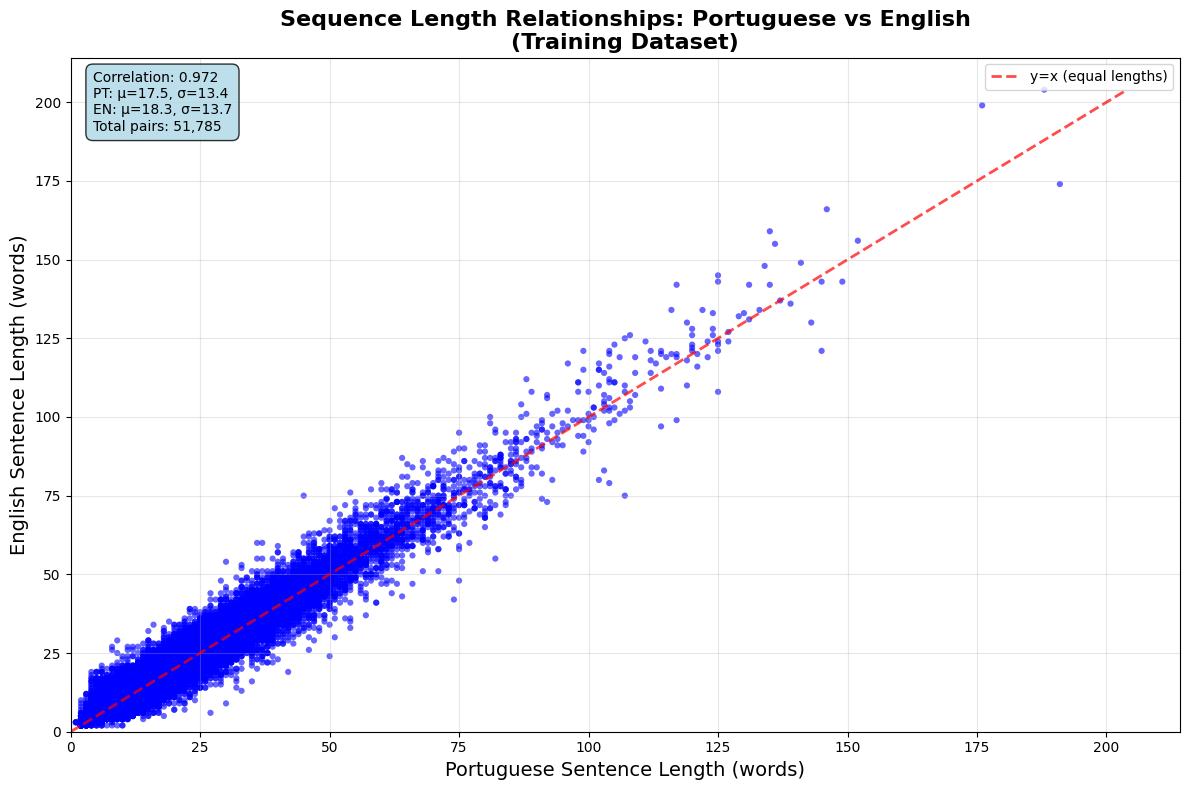


Sequence Length Analysis:
Portuguese sentences - Mean: 17.53, Std: 13.40
English sentences - Mean: 18.30, Std: 13.67
Length correlation: 0.9719
Max Portuguese length: 191 words
Max English length: 204 words

Largest length difference: 32 words
PT length: 107, EN length: 75


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Lists to store sequence lengths
pt_lengths = []
en_lengths = []

print("Analyzing sequence lengths in training dataset...")

# Process the training dataset in batches to analyze sequence lengths
for pt_batch, en_batch in train_examples.batch(1000):
    # Process each example in the batch
    for pt_sentence, en_sentence in zip(pt_batch.numpy(), en_batch.numpy()):
        # Decode bytes to strings and count words
        pt_text = pt_sentence.decode('utf-8')
        en_text = en_sentence.decode('utf-8')
        
        # Count words by splitting on whitespace
        pt_word_count = len(pt_text.split())
        en_word_count = len(en_text.split())
        
        # Store the lengths
        pt_lengths.append(pt_word_count)
        en_lengths.append(en_word_count)
    
    # Print progress indicator
    print('.', end='', flush=True)

print(f"\nProcessed {len(pt_lengths)} sentence pairs")

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(pt_lengths, en_lengths, alpha=0.6, s=20, c='blue', edgecolors='none')

# Add diagonal reference line (y=x) to show where lengths are equal
max_length = max(max(pt_lengths), max(en_lengths))
plt.plot([0, max_length], [0, max_length], 'r--', alpha=0.7, linewidth=2, label='y=x (equal lengths)')

# Customize the plot
plt.xlabel('Portuguese Sentence Length (words)', fontsize=14)
plt.ylabel('English Sentence Length (words)', fontsize=14)
plt.title('Sequence Length Relationships: Portuguese vs English\n(Training Dataset)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add statistics text box
correlation = np.corrcoef(pt_lengths, en_lengths)[0, 1]
mean_pt = np.mean(pt_lengths)
mean_en = np.mean(en_lengths)
std_pt = np.std(pt_lengths)
std_en = np.std(en_lengths)

stats_text = f'Correlation: {correlation:.3f}\n'
stats_text += f'PT: μ={mean_pt:.1f}, σ={std_pt:.1f}\n'
stats_text += f'EN: μ={mean_en:.1f}, σ={std_en:.1f}\n'
stats_text += f'Total pairs: {len(pt_lengths):,}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
         verticalalignment='top', fontsize=10)

# Set axis limits with some padding
plt.xlim(0, max_length * 1.05)
plt.ylim(0, max_length * 1.05)

# Save and show the plot
plt.tight_layout()
plt.savefig('assets/sequence_length_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# Print additional analysis
print(f"\nSequence Length Analysis:")
print(f"Portuguese sentences - Mean: {mean_pt:.2f}, Std: {std_pt:.2f}")
print(f"English sentences - Mean: {mean_en:.2f}, Std: {std_en:.2f}")
print(f"Length correlation: {correlation:.4f}")
print(f"Max Portuguese length: {max(pt_lengths)} words")
print(f"Max English length: {max(en_lengths)} words")

# Find examples with extreme length differences
length_diffs = [abs(pt - en) for pt, en in zip(pt_lengths, en_lengths)]
max_diff_idx = length_diffs.index(max(length_diffs))
print(f"\nLargest length difference: {max(length_diffs)} words")
print(f"PT length: {pt_lengths[max_diff_idx]}, EN length: {en_lengths[max_diff_idx]}")

## Define the components 🧩

There's a lot going on inside a Transformer. 🤖 The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder. 🔄
2. If you work through it step by step it will all make sense. 🪜✨

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer 🧩✨

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. ✨🔢

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer. 🧩🔢

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers, it needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance — `how are you`, `how you are`, `you how are`, and so on, are indistinguishable. 👜

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition, nearby elements will have similar position encodings. 🌊🔢

The original paper uses the following formula for calculating the positional encoding: ✨

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

> 📝 Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [27]:
def positional_encoding(length, depth):
  # The positional encoding uses sine and cosine functions at different frequencies.
  # The depth is split in half for sine and cosine components.
  depth = depth / 2

  # Create a column vector of positions (sequence indices), shape: (length, 1)
  positions = np.arange(length)[:, np.newaxis]

  # Create a row vector of normalized depths, shape: (1, depth)
  # This determines the frequency for each dimension.
  depths = np.arange(depth)[np.newaxis, :] / depth

  # Calculate the angle rates for each depth dimension.
  # This controls the frequency of the sine/cosine for each channel.
  angle_rates = 1 / (10000 ** depths)  # shape: (1, depth)

  # Compute the angle radians for each position and depth.
  # This is the core of the positional encoding formula.
  angle_rads = positions * angle_rates  # shape: (length, depth)

  # Concatenate the sine and cosine encodings along the last axis.
  # This doubles the depth, matching the original embedding dimension.
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1
  )

  # Convert the numpy array to a TensorFlow tensor of type float32.
  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


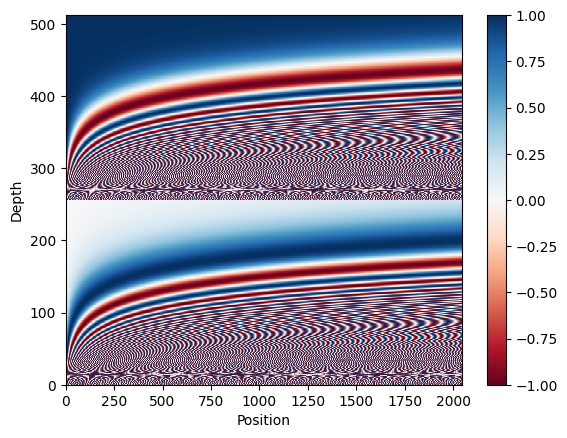

<Figure size 640x480 with 0 Axes>

In [28]:
#@title
# Generate positional encoding for a sequence of length 2048 and embedding depth 512.
# This encoding will be used to inject positional information into token embeddings.
pos_encoding = positional_encoding(length=2048, depth=512)

# Print the shape of the positional encoding tensor.
# Expected shape: (2048, 512), where 2048 is the sequence length and 512 is the embedding dimension.
print(pos_encoding.shape)

# Visualize the positional encoding matrix.
# Transpose the matrix so that each row corresponds to a depth dimension and each column to a position.
# Use a color mesh plot to show how the encoding values vary across positions and embedding dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')      # Y-axis: embedding dimension (depth)
plt.xlabel('Position')   # X-axis: sequence position
plt.colorbar()           # Add a color bar to indicate value scale
plt.show()               # Display the plot
plt.savefig('assets/positional_encoding.png')

By definition these vectors align well with nearby vectors along the position axis.  
Below, the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others: ✨🔢

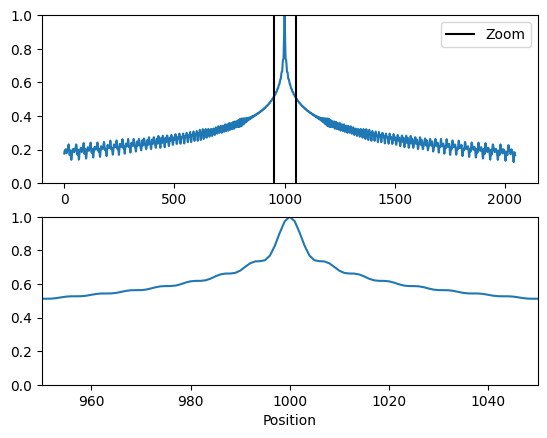

In [29]:
#@title
# Normalize each positional encoding vector to unit length along the depth axis.
# This ensures that the dot products below measure only the direction similarity, not magnitude.
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)

# Select the positional encoding vector at position 1000.
p = pos_encoding[1000]

# Compute the dot product between the position-1000 vector and every other position vector.
# tf.einsum('pd,d -> p', pos_encoding, p) computes the dot product for each position.
dots = tf.einsum('pd,d -> p', pos_encoding, p)

# Plot the dot products for all positions to visualize similarity with position 1000.
plt.subplot(2,1,1)
plt.plot(dots)                # Plot similarity across all positions.
plt.ylim([0,1])               # Limit y-axis to [0, 1] for clarity.

# Draw vertical lines to highlight the zoom region (positions 950 to 1050).
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()

# Plot a zoomed-in view of the dot products around position 1000.
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlabel('Position')
plt.xlim([950, 1050])         # Focus x-axis on positions near 1000.
plt.ylim([0,1])               # Keep y-axis limits consistent.

plt.savefig('assets/positional_encoding_similarity.png')    


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [30]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    # Embedding layer: maps token IDs to dense vectors of size d_model.
    # mask_zero=True ensures that padding tokens (ID=0) are masked out.
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    # Precompute positional encodings for sequences up to length 2048.
    # These encodings inject position information into the token embeddings.
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    # Propagate the mask from the embedding layer.
    # This allows downstream layers to ignore padding tokens.
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    # x: input tensor of token IDs, shape (batch_size, seq_len)
    length = tf.shape(x)[1]  # Get the sequence length for this batch.
    x = self.embedding(x)    # Convert token IDs to embedding vectors.
    # Scale embeddings by sqrt(d_model) as in the original Transformer paper.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # Add positional encoding to each token embedding.
    # pos_encoding is sliced to match the current sequence length.
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    # Return the combined embeddings (with position information).
    return x


> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

In [31]:
# Create positional embedding layers for Portuguese and English tokens.
# - vocab_size: Number of unique tokens in the tokenizer's vocabulary.
# - d_model: Dimensionality of the embedding vectors (512, as used in the Transformer model).
embed_pt = PositionalEmbedding(
    vocab_size=tokenizers.pt.get_vocab_size().numpy(),  # Portuguese vocab size
    d_model=512                                         # Embedding dimension
)
embed_en = PositionalEmbedding(
    vocab_size=tokenizers.en.get_vocab_size().numpy(),  # English vocab size
    d_model=512                                         # Embedding dimension
)

# Apply the positional embedding layers to the tokenized input sequences.
# - pt: Tensor of Portuguese token IDs (shape: [batch_size, seq_len])
# - en: Tensor of English token IDs (shape: [batch_size, seq_len])
# The output is a tensor of shape [batch_size, seq_len, d_model] for each language,
# where each token is represented by a vector that combines its learned embedding and positional encoding.
pt_emb = embed_pt(pt)  # Portuguese token embeddings with position encoding
en_emb = embed_en(en)  # English token embeddings with position encoding

In [32]:
# The _keras_mask attribute indicates which positions in the input are padding (masked out).
# This mask is automatically generated by the Embedding layer when mask_zero=True.
# It is a boolean tensor of shape (batch_size, sequence_length), where True means the token is not padding.
# This mask is used by subsequent layers (like attention) to ignore padding tokens during computation.
en_emb._keras_mask

<tf.Tensor: shape=(64, 47), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer. ✨➕📏

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 🧩

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs. 🚀

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not). 🛡️


### The base attention layer 🤖✨

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 🤖✨🧠

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear. 🤖✨

In [33]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    # MultiHeadAttention layer: computes attention over input sequences.
    # kwargs can include num_heads, key_dim, etc.
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # LayerNormalization: normalizes the output for stable training.
    self.layernorm = tf.keras.layers.LayerNormalization()
    # Add layer: adds residual connections (input + attention output).
    self.add = tf.keras.layers.Add()

#### Attention refresher 🤖✨

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs: 🤔🔍

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer 🤝✨

At the literal center of the Transformer is the cross-attention layer. 🤝✨ This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer: 🤝✨

In [34]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # Compute multi-head attention:
    # - query: the target sequence (x)
    # - key/value: the context sequence (context, typically encoder output)
    # - return_attention_scores=True: also returns the attention weights for visualization
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Store the attention scores for later analysis or visualization
    self.last_attn_scores = attn_scores

    # Add the attention output to the original input (residual connection)
    x = self.add([x, attn_output])
    # Normalize the result for stable training
    x = self.layernorm(x)

    # Return the processed output (same shape as input x)
    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence. 🎨🔄

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence. 🕵️‍♂️🔑

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix. 🎨
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries. 👀🔄

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [35]:
# Create a CrossAttention layer instance with 2 attention heads and key dimension of 512.
# This layer will allow the decoder (English embeddings) to attend to the encoder (Portuguese embeddings).
sample_ca = CrossAttention(num_heads=2, key_dim=512)

# Print the shape of the Portuguese token embeddings with positional encoding.
# pt_emb: Tensor of shape (batch_size, pt_seq_len, d_model)
print(pt_emb.shape)

# Print the shape of the English token embeddings with positional encoding.
# en_emb: Tensor of shape (batch_size, en_seq_len, d_model)
print(en_emb.shape)

# Pass the English embeddings (as queries) and Portuguese embeddings (as context) to the CrossAttention layer.
# This computes attention from each English token to all Portuguese tokens.
# The output shape matches the input query shape: (batch_size, en_seq_len, d_model)
print(sample_ca(en_emb, pt_emb).shape)

(64, 56, 512)
(64, 47, 512)
(64, 47, 512)


### The global self-attention layer 🤖✨

This layer is responsible for processing the context sequence, and propagating information along its length: 🔄✨

<table>
<tr>
  <th colspan=1>The global self-attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 🔄

Before Transformers and self-attention, models commonly used RNNs or CNNs to do this task: 🤖🧠

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations. 🤔

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices. 🐢
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions). 🏗️

The global self-attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. ⚡🤖

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer:

In [36]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # Compute multi-head self-attention:
    # - query: the input sequence (x)
    # - key: the input sequence (x)
    # - value: the input sequence (x)
    # This allows every position in the sequence to attend to every other position.
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    # Add the attention output to the original input (residual connection).
    x = self.add([x, attn_output])
    # Normalize the result for stable training.
    x = self.layernorm(x)
    # Return the processed output (same shape as input x).
    return x

In [37]:
# Create an instance of the GlobalSelfAttention layer.
# - num_heads=2: The attention mechanism will use 2 separate attention heads.
# - key_dim=512: Each attention head projects the input to a 512-dimensional space.
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

# Print the shape of the Portuguese token embeddings with positional encoding.
# pt_emb: Tensor of shape (batch_size, sequence_length, embedding_dim)
print(pt_emb.shape)

# Pass the Portuguese embeddings through the GlobalSelfAttention layer.
# This allows each token in the sequence to attend to every other token in the same sequence.
# The output shape matches the input: (batch_size, sequence_length, embedding_dim)
print(sample_gsa(pt_emb).shape)

(64, 56, 512)


(64, 56, 512)


Sticking with the same style as before you could draw it like this: 🎨✨

<table>
<tr>
  <th colspan=1>The global self-attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity. 😊

It's more compact, and just as accurate to draw it like this: 🎨

<table>
<tr>
  <th colspan=1>The global self-attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self-attention layer ⏩🤖✨

This layer does a similar job as the global self-attention layer, for the output sequence: ⏩🤖✨

<table>
<tr>
  <th colspan=1>The causal self-attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self-attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation) and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal". ⏩🤖✨

A single-direction RNN is causal by definition. 🕒 To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) . 🧩➡️

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: ⚡⏩

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once. 🏋️‍♂️
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused. 🔄
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor). 🧠
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482) 🚀

To build a causal self-attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s. 🛡️✨

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it: 🤖⏩

In [38]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    # Compute multi-head self-attention with a causal mask:
    # - query: the input sequence (x)
    # - key: the input sequence (x)
    # - value: the input sequence (x)
    # - use_causal_mask=True: ensures that each position can only attend to previous positions (not future ones)
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True)
    # Add the attention output to the original input (residual connection)
    x = self.add([x, attn_output])
    # Normalize the result for stable training
    x = self.layernorm(x)
    # Return the processed output (same shape as input x)
    return x

The causal mask ensures that each location only has access to the locations that come before it:

<table>
<tr>
  <th colspan=1>The causal self-attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self-attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [39]:
# Create an instance of the CausalSelfAttention layer.
# - num_heads=2: The attention mechanism will use 2 separate attention heads.
# - key_dim=512: Each attention head projects the input to a 512-dimensional space.
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

# Print the shape of the English token embeddings with positional encoding.
# en_emb: Tensor of shape (batch_size, sequence_length, embedding_dim)
print(en_emb.shape)

# Pass the English embeddings through the CausalSelfAttention layer.
# This allows each token in the sequence to attend only to previous tokens (not future ones),
# enforcing causality for autoregressive decoding.
# The output shape matches the input: (batch_size, sequence_length, embedding_dim)
print(sample_csa(en_emb).shape)

(64, 47, 512)


(64, 47, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [40]:
# Compute the output of the CausalSelfAttention layer on the first 3 tokens of each sequence.
# - en[:, :3]: Selects the first 3 tokens from each sequence in the English input batch.
# - embed_en(en[:, :3]): Applies the positional embedding to these tokens.
# - sample_csa(...): Passes the embedded tokens through the causal self-attention layer.
out1 = sample_csa(embed_en(en[:, :3]))

# Compute the output of the CausalSelfAttention layer on the full sequence,
# then select only the first 3 tokens from the output.
# - embed_en(en): Applies positional embedding to the full English input batch.
# - sample_csa(...): Passes the full embedded sequence through the causal self-attention layer.
# - ...[:, :3]: Selects the first 3 tokens from the output sequence.
out2 = sample_csa(embed_en(en))[:, :3]

# Calculate the maximum absolute difference between the two outputs.
# - abs(out1 - out2): Element-wise absolute difference between the two tensors.
# - tf.reduce_max(...): Finds the maximum value in the difference tensor.
# - .numpy(): Converts the result to a NumPy scalar for display.
tf.reduce_max(abs(out1 - out2)).numpy()

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


np.float32(0.0)

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. ⚠️🤖

### The feed forward network ⚡🧠

The transformer also includes this point-wise feed-forward network in both the encoder and decoder: ⚡🧠

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization: ⚡🧠➕📏

In [41]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    # Sequential block: two dense layers with ReLU and dropout in between.
    # - First Dense: expands to dff units (hidden size), ReLU activation.
    # - Second Dense: projects back to d_model (original embedding size).
    # - Dropout: regularizes the output to prevent overfitting.
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),   # Hidden layer with ReLU
      tf.keras.layers.Dense(d_model),                  # Output layer, restores original size
      tf.keras.layers.Dropout(dropout_rate)            # Dropout for regularization
    ])
    # Add layer for residual connection (input + output of FFN)
    self.add = tf.keras.layers.Add()
    # LayerNormalization to stabilize training and scale outputs
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    # Apply the feed-forward network to the input
    # Add the input (residual connection) to the output of the FFN
    x = self.add([x, self.seq(x)])
    # Normalize the result for stable training
    x = self.layer_norm(x)
    # Return the processed tensor
    return x


Test the layer, the output is the same shape as the input:

In [42]:
# Create an instance of the FeedForward layer.
# - d_model=512: The input and output dimensionality of the layer (matches embedding size).
# - dff=2048: The hidden layer size inside the feed-forward network.
sample_ffn = FeedForward(512, 2048)

# Print the shape of the English token embeddings with positional encoding.
# en_emb: Tensor of shape (batch_size, sequence_length, embedding_dim)
print(en_emb.shape)

# Pass the English embeddings through the FeedForward layer.
# The output shape matches the input: (batch_size, sequence_length, embedding_dim)
# This layer applies two dense layers with ReLU and dropout, then adds a residual connection and normalizes the result.
print(sample_ffn(en_emb).shape)

(64, 47, 512)
(64, 47, 512)


### The encoder layer 🧩✨

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer: 🧩✨

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    # GlobalSelfAttention: allows each token in the input sequence to attend to every other token.
    # - num_heads: Number of attention heads.
    # - key_dim: Dimensionality of each attention head (usually matches d_model).
    # - dropout: Dropout rate for regularization.
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # FeedForward: point-wise feed-forward network applied to each position.
    # - d_model: Input/output dimensionality (matches embedding size).
    # - dff: Hidden layer size inside the feed-forward network.
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    # Apply global self-attention to the input sequence.
    # This propagates information along the sequence.
    x = self.self_attention(x)
    # Apply the feed-forward network to each position in the sequence.
    x = self.ffn(x)
    # Return the processed sequence (same shape as input).
    return x

And a quick test, the output will have the same shape as the input:

In [44]:
# Create an instance of the EncoderLayer.
# - d_model=512: The dimensionality of the input and output vectors (embedding size).
# - num_heads=8: Number of attention heads in the multi-head attention mechanism.
# - dff=2048: The hidden layer size inside the feed-forward network.
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# Print the shape of the Portuguese token embeddings with positional encoding.
# pt_emb: Tensor of shape (batch_size, sequence_length, embedding_dim)
print(pt_emb.shape)

# Pass the Portuguese embeddings through the EncoderLayer.
# The EncoderLayer applies:
#   1. Global self-attention: Each token attends to every other token in the sequence.
#   2. Feed-forward network: Point-wise transformation of each token embedding.
# The output shape matches the input: (batch_size, sequence_length, embedding_dim)
print(sample_encoder_layer(pt_emb).shape)

(64, 56, 512)


(64, 56, 512)


### The encoder 🧩✨

Next build the encoder. 🏗️✨

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of: 🏗️✨

- A `PositionalEmbedding` layer at the input. 🧩🔢
- A stack of `EncoderLayer` layers. 🧱🧱🧱

In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    # Store the model dimension and number of layers for reference
    self.d_model = d_model
    self.num_layers = num_layers

    # PositionalEmbedding: Converts token IDs to embeddings and adds positional encoding
    # - vocab_size: Number of unique tokens in the vocabulary
    # - d_model: Dimensionality of the embedding vectors
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    # Stack of EncoderLayer instances
    # Each EncoderLayer contains:
    #   - GlobalSelfAttention: lets each token attend to every other token in the sequence
    #   - FeedForward: point-wise feed-forward network
    # - num_layers: Number of layers to stack
    # - d_model: Embedding dimension
    # - num_heads: Number of attention heads
    # - dff: Hidden layer size in the feed-forward network
    # - dropout_rate: Dropout rate for regularization
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Dropout layer applied after positional embedding for regularization
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # Input x: token IDs of shape (batch_size, seq_len)
    # Convert token IDs to embeddings and add positional encoding
    x = self.pos_embedding(x)  # Shape: (batch_size, seq_len, d_model)

    # Apply dropout to the embeddings
    x = self.dropout(x)

    # Pass the embeddings through each EncoderLayer in the stack
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    # Output: processed sequence of shape (batch_size, seq_len, d_model)
    return x

Test the encoder:

In [46]:
# Instantiate the encoder with the specified configuration:
# - num_layers=4: The encoder will have 4 stacked EncoderLayer blocks.
# - d_model=512: Each token embedding and hidden state will have 512 dimensions.
# - num_heads=8: Multi-head attention will use 8 parallel attention heads.
# - dff=2048: The feed-forward network inside each EncoderLayer will expand to 2048 units before projecting back to d_model.
# - vocab_size=8500: The vocabulary size for the input tokens (number of unique tokens).
sample_encoder = Encoder(
    num_layers=4,      # Number of encoder layers to stack
    d_model=512,       # Dimensionality of embeddings and hidden states
    num_heads=8,       # Number of attention heads in MultiHeadAttention
    dff=2048,          # Hidden layer size in the feed-forward network
    vocab_size=8500    # Size of the input vocabulary
)

# Pass the Portuguese token IDs (pt) through the encoder.
# - pt: Tensor of shape (batch_size, input_seq_len), containing token IDs for each input sentence.
# - training=False: Indicates that the encoder is running in inference mode (no dropout applied).
# The encoder will:
#   1. Embed the input tokens and add positional encoding.
#   2. Apply dropout (skipped if training=False).
#   3. Pass the embeddings through 4 stacked EncoderLayer blocks.
#   4. Each EncoderLayer applies global self-attention and a feed-forward network.
# The output is a tensor of shape (batch_size, input_seq_len, d_model), representing the encoded input sequence.
sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape of the input token IDs tensor.
print(f"Shape of input token IDs (pt): {pt.shape}") # Shape: (batch_size, input_seq_len)

# Print the shape of the encoder output tensor.
# The output shape should be (batch_size, input_seq_len, d_model), where:
#   - batch_size: Number of input sequences in the batch
#   - input_seq_len: Length of each input sequence (number of tokens)
#   - d_model: Dimensionality of the encoder output vectors (512)
print(f"Shape of encoder output: {sample_encoder_output.shape}") # Shape `(batch_size, input_seq_len, d_model)`.

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Shape of input token IDs (pt): (64, 56)
Shape of encoder output: (64, 56, 512)


### The decoder layer 🧩✨

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention` ⏩🤖, a `CrossAttention` 🤝✨, and a `FeedForward` ⚡🧠 layer:

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # CausalSelfAttention: allows each token in the output sequence to attend only to previous tokens (not future ones).
    # - num_heads: Number of attention heads.
    # - key_dim: Dimensionality of each attention head (usually matches d_model).
    # - dropout: Dropout rate for regularization.
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # CrossAttention: allows each token in the output sequence to attend to all tokens in the encoder output (context).
    # - num_heads: Number of attention heads.
    # - key_dim: Dimensionality of each attention head (usually matches d_model).
    # - dropout: Dropout rate for regularization.
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # FeedForward: point-wise feed-forward network applied to each position in the sequence.
    # - d_model: Input/output dimensionality (matches embedding size).
    # - dff: Hidden layer size inside the feed-forward network.
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # Apply causal self-attention to the input sequence (decoder input).
    # This enforces autoregressive decoding by masking future tokens.
    x = self.causal_self_attention(x=x)

    # Apply cross-attention, allowing the decoder to attend to the encoder output (context).
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores from the cross-attention layer for visualization or analysis.
    self.last_attn_scores = self.cross_attention.last_attn_scores

    # Apply the feed-forward network to each position in the sequence.
    # The output shape matches the input: (batch_size, seq_len, d_model).
    x = self.ffn(x)
    return x

Test the decoder layer:

In [48]:
# Instantiate a DecoderLayer with the specified configuration:
# - d_model=512: Dimensionality of the input and output vectors (embedding size).
# - num_heads=8: Number of attention heads in the multi-head attention mechanism.
# - dff=2048: Hidden layer size inside the feed-forward network.
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

# Pass the English token embeddings (en_emb) and Portuguese token embeddings (pt_emb) to the decoder layer.
# - x=en_emb: The input to the decoder (target sequence embeddings with positional encoding).
# - context=pt_emb: The encoder output (source sequence embeddings with positional encoding).
# The DecoderLayer applies:
#   1. Causal self-attention: Each token in the target sequence attends only to previous tokens (autoregressive).
#   2. Cross-attention: Each token in the target sequence attends to all tokens in the source sequence (encoder output).
#   3. Feed-forward network: Point-wise transformation of each token embedding.
# The output shape matches the input: (batch_size, seq_len, d_model)
sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

# Print the shape of the English token embeddings (input to the decoder).
print(f'Shape of English token embeddings (en_emb): {en_emb.shape}')  # Shape: (batch_size, target_seq_len, d_model)

# Print the shape of the Portuguese token embeddings (encoder output/context).
print(f'Shape of Portuguese token embeddings (pt_emb): {pt_emb.shape}')  # Shape: (batch_size, source_seq_len, d_model)

# Print the shape of the decoder layer output.
# The output shape should be (batch_size, target_seq_len, d_model), where:
#   - batch_size: Number of sequences in the batch
#   - target_seq_len: Length of each target sequence (number of tokens)
#   - d_model: Dimensionality of the decoder output vectors (512)
print(f'Shape of decoder layer output: {sample_decoder_layer_output.shape}')  # Shape `(batch_size, seq_len, d_model)`

Shape of English token embeddings (en_emb): (64, 47, 512)
Shape of Portuguese token embeddings (pt_emb): (64, 56, 512)
Shape of decoder layer output: (64, 47, 512)


### The decoder 🧩✨

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [49]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    # Store model hyperparameters for reference
    self.d_model = d_model
    self.num_layers = num_layers

    # PositionalEmbedding: Converts token IDs to embeddings and adds positional encoding
    # - vocab_size: Number of unique tokens in the vocabulary
    # - d_model: Dimensionality of the embedding vectors
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    # Dropout layer for regularization after embedding
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    # Stack of DecoderLayer instances
    # Each DecoderLayer contains:
    #   - CausalSelfAttention: lets each token attend only to previous tokens in the sequence
    #   - CrossAttention: lets each token attend to all tokens in the encoder output
    #   - FeedForward: point-wise feed-forward network
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Will store the attention scores from the last DecoderLayer for visualization/analysis
    self.last_attn_scores = None

  def call(self, x, context):
    # x: token IDs of shape (batch_size, target_seq_len)
    # context: encoder output, shape (batch_size, input_seq_len, d_model)

    # Convert token IDs to embeddings and add positional encoding
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    # Apply dropout to the embeddings
    x = self.dropout(x)

    # Pass the embeddings through each DecoderLayer in the stack
    # Each layer applies causal self-attention, cross-attention, and feed-forward network
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    # Cache the last attention scores from the final DecoderLayer for visualization/analysis
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # Output: processed sequence of shape (batch_size, target_seq_len, d_model)
    return x

Test the decoder:

In [50]:
# Instantiate the decoder with the specified configuration:
# - num_layers=4: The decoder will have 4 stacked DecoderLayer blocks.
# - d_model=512: Each token embedding and hidden state will have 512 dimensions.
# - num_heads=8: Multi-head attention will use 8 parallel attention heads.
# - dff=2048: The feed-forward network inside each DecoderLayer will expand to 2048 units before projecting back to d_model.
# - vocab_size=8000: The vocabulary size for the target language tokens.
sample_decoder = Decoder(
    num_layers=4,      # Number of decoder layers to stack
    d_model=512,       # Dimensionality of embeddings and hidden states
    num_heads=8,       # Number of attention heads in MultiHeadAttention
    dff=2048,          # Hidden layer size in the feed-forward network
    vocab_size=8000    # Size of the target vocabulary
)

# Pass the English token IDs (en) and Portuguese embeddings (pt_emb) to the decoder.
# - x=en: Tensor of shape (batch_size, target_seq_len), containing token IDs for each target sentence.
# - context=pt_emb: Tensor of shape (batch_size, source_seq_len, d_model), containing encoder output embeddings.
# The decoder will:
#   1. Embed the target tokens and add positional encoding.
#   2. Apply dropout (if training).
#   3. Pass the embeddings through 4 stacked DecoderLayer blocks.
#   4. Each DecoderLayer applies causal self-attention, cross-attention, and a feed-forward network.
# The output is a tensor of shape (batch_size, target_seq_len, d_model), representing the decoded sequence.
output = sample_decoder(
    x=en,         # Target token IDs
    context=pt_emb  # Encoder output embeddings
)

# Print the shapes of the input and output tensors for verification.
print(en.shape)        # Shape: (batch_size, target_seq_len) - input token IDs
print(pt_emb.shape)    # Shape: (batch_size, source_seq_len, d_model) - encoder output
print(output.shape)    # Shape: (batch_size, target_seq_len, d_model) - decoder output

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 47)
(64, 56, 512)
(64, 47, 512)


In [51]:
# The attention scores from the last DecoderLayer in the sample_decoder.
# This tensor contains the cross-attention weights, showing how much each target token (in the output sequence)
# attends to each input token (in the encoder output) for each attention head and batch.
# The shape of the tensor is (batch_size, num_heads, target_seq_len, input_seq_len):
#   - batch_size: Number of sequences in the batch.
#   - num_heads: Number of attention heads in the decoder.
#   - target_seq_len: Length of the output (target) sequence.
#   - input_seq_len: Length of the input (source) sequence.
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 47, 56])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it. 🚀🤖✨

## Extracting Embeddings for Tokenized Words

To extract embeddings for specific words in your transformer model, you need to:

1. **Tokenize the words properly** - Convert strings to token IDs using the tokenizer
2. **Convert to tensor** - Ensure the token IDs are in the right format (tensor, not list)
3. **Access the embedding layer** - Use the correct path to the embedding layer
4. **Extract embeddings** - Get the dense vector representations

Let's demonstrate the correct approach:

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Method 1: Extract embeddings using the Portuguese tokenizer and embedding layer
print("=== Method 1: Using Portuguese Tokenizer and Encoder Embedding ===")

# Define words of interest in Portuguese
words_of_interest = ['ler', 'literatura', 'livro', 'estudar','correr']  # 'to read', 'literature', 'book', 'to study'

# Step 1: Tokenize each word individually and collect token IDs
token_ids = []
for word in words_of_interest:
    # Tokenize the word (returns a RaggedTensor)
    word_tensor = tf.constant([word])  # Convert to tensor format
    tokenized = tokenizers.pt.tokenize(word_tensor)
    
    # Extract the first (and usually only) token ID for the word
    # Some words might be split into multiple subwords
    token_id = tokenized.numpy()[0][0]  # First batch, first token
    token_ids.append(token_id)
    print(f"Word: '{word}' -> Token ID: {token_id}")

# Step 2: Convert token IDs to tensor
token_ids_tensor = tf.constant(token_ids, dtype=tf.int32)
print(f"\nToken IDs tensor: {token_ids_tensor}")

# Step 3: Extract embeddings from the encoder's embedding layer
# The encoder has a positional embedding layer that contains the token embeddings
embeddings = embed_pt.embedding(token_ids_tensor).numpy()
print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Each embedding has {embeddings.shape[1]} dimensions")

# Display first few dimensions of each embedding
print("\nFirst 10 dimensions of each word embedding:")
for i, word in enumerate(words_of_interest):
    print(f"{word}: {embeddings[i][:10]}")

print("\n" + "="*60)

=== Method 1: Using Portuguese Tokenizer and Encoder Embedding ===
Word: 'ler' -> Token ID: 2
Word: 'literatura' -> Token ID: 2
Word: 'livro' -> Token ID: 2
Word: 'estudar' -> Token ID: 2
Word: 'correr' -> Token ID: 2

Token IDs tensor: [2 2 2 2 2]

Embeddings shape: (5, 512)
Each embedding has 512 dimensions

First 10 dimensions of each word embedding:
ler: [ 0.01834304 -0.0297721  -0.04636304 -0.03920859  0.02385462 -0.03546389
  0.00195643 -0.0378054   0.04256854  0.00492596]
literatura: [ 0.01834304 -0.0297721  -0.04636304 -0.03920859  0.02385462 -0.03546389
  0.00195643 -0.0378054   0.04256854  0.00492596]
livro: [ 0.01834304 -0.0297721  -0.04636304 -0.03920859  0.02385462 -0.03546389
  0.00195643 -0.0378054   0.04256854  0.00492596]
estudar: [ 0.01834304 -0.0297721  -0.04636304 -0.03920859  0.02385462 -0.03546389
  0.00195643 -0.0378054   0.04256854  0.00492596]
correr: [ 0.01834304 -0.0297721  -0.04636304 -0.03920859  0.02385462 -0.03546389
  0.00195643 -0.0378054   0.04256854  

You now have `Encoder` 🧩 and `Decoder` 🧩. To complete the `Transformer` model 🚀🤖✨, you need to put them together and add a final linear (`Dense`) layer 🧠 which converts the resulting vector at each location into output token probabilities 🔢.

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). 🤖✨ A multi-layer Transformer has more layers, but is fundamentally doing the same thing. 🧩🔄

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model` 🤖✨:

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4, shares the weight matrix between the embedding layer and the final linear layer. To keep things simple, this tutorial uses two separate weight matrices.

In [53]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    # Encoder: Processes the input sequence and produces a context representation.
    # - num_layers: Number of stacked EncoderLayer blocks.
    # - d_model: Dimensionality of embeddings and hidden states.
    # - num_heads: Number of attention heads in MultiHeadAttention.
    # - dff: Hidden layer size in the feed-forward network.
    # - vocab_size: Size of the input vocabulary.
    # - dropout_rate: Dropout rate for regularization.
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    # Decoder: Processes the target sequence and attends to the encoder output.
    # - num_layers: Number of stacked DecoderLayer blocks.
    # - d_model: Dimensionality of embeddings and hidden states.
    # - num_heads: Number of attention heads in MultiHeadAttention.
    # - dff: Hidden layer size in the feed-forward network.
    # - vocab_size: Size of the target vocabulary.
    # - dropout_rate: Dropout rate for regularization.
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    # Final linear layer: Projects decoder outputs to logits for each target token.
    # - target_vocab_size: Number of possible output tokens.
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # The call method defines the forward pass of the model.
    # Inputs:
    #   - inputs: Tuple (context, x)
    #     - context: Input token IDs (source sequence), shape (batch_size, context_len)
    #     - x: Target token IDs (target sequence), shape (batch_size, target_len)
    context, x  = inputs

    # Pass the input tokens through the encoder to get the context representation.
    # Output shape: (batch_size, context_len, d_model)
    context = self.encoder(context)

    # Pass the target tokens and context through the decoder.
    # Output shape: (batch_size, target_len, d_model)
    x = self.decoder(x, context)

    # Project the decoder output to logits for each token in the target vocabulary.
    # Output shape: (batch_size, target_len, target_vocab_size)
    logits = self.final_layer(x)

    try:
      # Remove the Keras mask from logits to avoid affecting loss/metrics calculations.
      # This is a workaround for a known issue (b/250038731).
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the logits (predicted token probabilities for each position).
    return logits

### Hyperparameters ⚙️✨

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced. ⚡✨

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`. 📄🤖

The number of self-attention heads remains the same (`num_heads=8`). 🧠🔄


In [54]:
# Set the hyperparameters for the Transformer model.
# These control the size and complexity of the model.

num_layers = 4        # Number of encoder/decoder layers to stack in the Transformer.
d_model = 128         # Dimensionality of the embedding vectors and hidden states.
dff = 512             # Dimensionality of the feed-forward network's hidden layer.
num_heads = 8         # Number of attention heads in the MultiHeadAttention layers.
dropout_rate = 0.1    # Dropout rate for regularization to prevent overfitting.

### Try it out 🚀🤖✨

Instantiate the `Transformer` model:

In [55]:
# Instantiate the Transformer model with the specified hyperparameters and vocabulary sizes.
# - num_layers: Number of encoder and decoder layers to stack in the Transformer.
# - d_model: Dimensionality of the embedding vectors and hidden states.
# - num_heads: Number of attention heads in the MultiHeadAttention layers.
# - dff: Dimensionality of the feed-forward network's hidden layer.
# - input_vocab_size: Size of the input vocabulary (Portuguese), obtained from the tokenizer.
# - target_vocab_size: Size of the target vocabulary (English), obtained from the tokenizer.
# - dropout_rate: Dropout rate for regularization to prevent overfitting.
transformer = Transformer(
    num_layers=num_layers,                          # Number of layers in encoder/decoder
    d_model=d_model,                                # Embedding and hidden state size
    num_heads=num_heads,                            # Number of attention heads
    dff=dff,                                        # Feed-forward network hidden size
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),   # Portuguese vocab size
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),  # English vocab size
    dropout_rate=dropout_rate                       # Dropout rate for regularization
)

Test it:

In [56]:
# Pass the Portuguese and English token IDs through the Transformer model.
# - pt: Tensor of shape (batch_size, input_seq_len), containing token IDs for the source (Portuguese) sentences.
# - en: Tensor of shape (batch_size, target_seq_len), containing token IDs for the target (English) sentences.
# The transformer model will:
#   1. Encode the Portuguese input sequence using the encoder stack.
#   2. Decode the English target sequence using the decoder stack, attending to the encoder output.
#   3. Project the decoder output to logits for each token in the target vocabulary.
output = transformer((pt, en))

# Print the shape of the English token IDs tensor (target sequence).
# This shows the batch size and target sequence length.
print(en.shape)

# Print the shape of the Portuguese token IDs tensor (source sequence).
# This shows the batch size and input sequence length.
print(pt.shape)

# Print the shape of the output tensor from the Transformer model.
# The output shape is (batch_size, target_seq_len, target_vocab_size), representing the predicted logits for each token position in the target sequence.
print(output.shape)

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a 

(64, 47)
(64, 56)
(64, 47, 7010)


In [57]:
# Retrieve the cross-attention scores from the last DecoderLayer in the Transformer.
# - transformer.decoder.dec_layers[-1]: Accesses the last DecoderLayer in the decoder stack.
# - last_attn_scores: Stores the cross-attention weights from the most recent forward pass.
#   These scores indicate how much each target token (in the output sequence) attends to each input token (in the encoder output),
#   for every attention head and batch in the input.
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores

# Print the shape of the attention scores tensor.
# The shape is (batch_size, num_heads, target_seq_len, input_seq_len), where:
#   - batch_size: Number of sequences in the batch.
#   - num_heads: Number of attention heads in the decoder.
#   - target_seq_len: Length of the output (target) sequence.
#   - input_seq_len: Length of the input (source) sequence.
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 47, 56)


Print the summary of the model:

In [58]:
# Install the pydot package, which is used for generating and visualizing graphs in Python.
# pydot is often used together with Graphviz for plotting model architectures, especially in TensorFlow and Keras.
# The commented-out line shows how to install Graphviz via apt (for Linux systems), which is required for rendering graphs.
# For most use cases in Jupyter, installing pydot via pip is sufficient if Graphviz is already available on your system.
!pip install pydot

In [59]:
# Import the plot_model utility from TensorFlow Keras.
# This function generates a visual diagram of the model architecture.
from tensorflow.keras.utils import plot_model

# Visualize the architecture of the 'transformer' model.
# - transformer: The model instance to visualize.
# - show_shapes=True: Display the shape of the input and output tensors for each layer.
# - dpi=64: Set the resolution of the generated image (dots per inch).
# - rankdir='LR': Arrange the diagram from left to right (horizontal layout).
plot_model(transformer, show_shapes=True, dpi=64, rankdir='LR')

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Training 🏋️‍♂️✨

It's time to prepare the model and start training it. 🚀

### Set up the optimizer ⚡🧠✨

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [67]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):  # Reduce warmup steps
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    # Add a base learning rate multiplier for faster convergence
    base_lr = 2.0  # Increase base learning rate
    return base_lr * tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Update optimizer with higher base learning rate
learning_rate = CustomSchedule(d_model, warmup_steps=1000)  # Shorter warmup
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [68]:
# Create a custom learning rate schedule using the formula from the original Transformer paper.
# - d_model: Dimensionality of the model's embeddings and hidden states.
# The learning rate will increase linearly for the first 'warmup_steps' training steps,
# then decay proportionally to the inverse square root of the step number.
learning_rate = CustomSchedule(d_model)

# Instantiate the Adam optimizer for training the Transformer model.
# - learning_rate: Uses the custom schedule defined above.
# - beta_1=0.9: Exponential decay rate for the first moment estimates (default for Adam).
# - beta_2=0.98: Exponential decay rate for the second moment estimates (slightly higher than default).
# - epsilon=1e-9: Small constant to prevent division by zero in the optimizer's update step.
optimizer = tf.keras.optimizers.Adam(
    learning_rate,      # Custom learning rate schedule
    beta_1=0.9,         # Decay rate for first moment estimates
    beta_2=0.98,        # Decay rate for second moment estimates
    epsilon=1e-9        # Numerical stability constant
)

Test the custom learning rate scheduler:

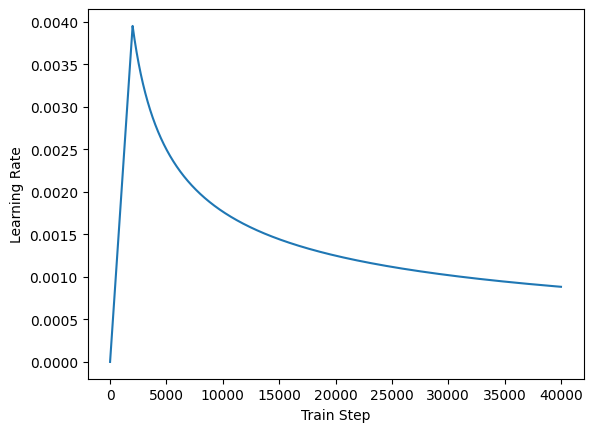

In [69]:
# Plot the learning rate schedule over training steps.
# - learning_rate: Custom learning rate scheduler (instance of CustomSchedule).
# - tf.range(40000, dtype=tf.float32): Generates a tensor of training steps from 0 to 39,999.
# - learning_rate(...): Computes the learning rate for each training step.
# - plt.plot(...): Plots the computed learning rates against training steps.
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))

# Set the label for the y-axis to indicate it represents the learning rate.
plt.ylabel('Learning Rate')

# Set the label for the x-axis to indicate it represents the training step number.
plt.xlabel('Train Step')

plt.savefig('assets/learning_rate.png')

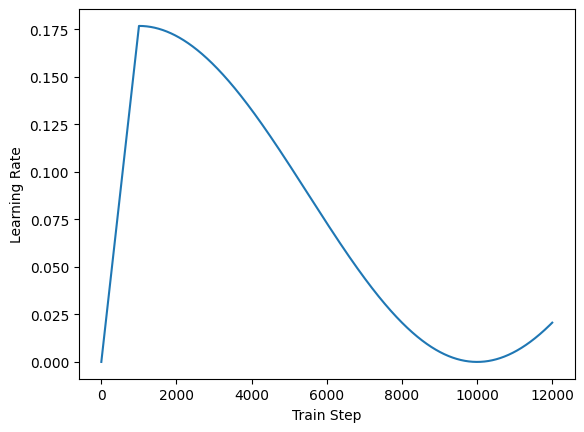

In [73]:
class WarmupCosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000, total_steps=10000, min_lr=1e-6):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        self.max_lr = 2.0 * tf.math.rsqrt(self.d_model)
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        
        # Warmup phase
        warmup_lr = (self.max_lr / self.warmup_steps) * step
        
        # Cosine annealing phase
        cosine_lr = self.min_lr + (self.max_lr - self.min_lr) * 0.5 * (
            1 + tf.cos(3.14159 * (step - self.warmup_steps) / (self.total_steps - self.warmup_steps))
        )
        
        return tf.where(step < self.warmup_steps, warmup_lr, cosine_lr)

# plot the new learning rate schedule
learning_rate = WarmupCosineSchedule(d_model, warmup_steps=1000, total_steps=10000)
plt.plot(learning_rate(tf.range(12000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.savefig('assets/warmup_cosine_learning_rate.png')

### Set up the loss and metrics ⚡📏✨

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [70]:
def masked_loss(label, pred):
  # Create a mask to ignore padding tokens (assumed to be 0)
  mask = label != 0

  # Define the loss function: SparseCategoricalCrossentropy
  # - from_logits=True: pred contains raw logits, not probabilities
  # - reduction='none': compute loss for each element, don't reduce yet
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

  # Compute the per-token loss
  loss = loss_object(label, pred)

  # Cast the mask to the same dtype as loss (float32)
  mask = tf.cast(mask, dtype=loss.dtype)

  # Apply the mask: zero out loss for padding tokens
  loss *= mask

  # Compute the mean loss over non-padding tokens
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  # Get the predicted token IDs by taking argmax over the last axis (vocab)
  pred = tf.argmax(pred, axis=2)

  # Cast label to the same dtype as pred for comparison
  label = tf.cast(label, pred.dtype)

  # Compare predicted tokens to true labels
  match = label == pred

  # Create a mask to ignore padding tokens (assumed to be 0)
  mask = label != 0

  # Only count matches for non-padding tokens
  match = match & mask

  # Cast match and mask to float for averaging
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  # Compute accuracy as the mean over non-padding tokens
  return tf.reduce_sum(match) / tf.reduce_sum(mask)

### Train the model 🏋️‍♂️🤖✨

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`: 🏋️‍♂️🤖✨

Note: This takes about an hour to train in Colab. ⏳💻

In [74]:
# Compile the Transformer model for training.
# - loss: masked_loss function, which computes cross-entropy loss while ignoring padding tokens.
# - optimizer: Adam optimizer with a custom learning rate schedule (optimizer variable).
# - metrics: masked_accuracy function, which computes accuracy while ignoring padding tokens.
# This prepares the model for training with model.fit, ensuring that loss and metrics are calculated correctly for padded sequences.
transformer.compile(
    loss=masked_loss,          # Custom loss function that ignores padding tokens
    optimizer=optimizer,       # Adam optimizer with custom learning rate schedule
    metrics=[masked_accuracy]  # Custom accuracy metric that ignores padding tokens
)

In [75]:
# Train the Transformer model using the training and validation datasets.
# - transformer.fit: Starts the training process for the model.
# - train_batches: The training dataset, batched and prefetched for efficiency.
# - epochs=20: Train the model for 20 complete passes through the training data.
# - validation_data=val_batches: Use the validation dataset to evaluate the model after each epoch.
# During training:
#   1. The model receives batches of input and target sequences from train_batches.
#   2. For each batch, it computes predictions, calculates the masked loss and accuracy, and updates weights using the optimizer.
#   3. After each epoch, the model evaluates its performance on val_batches to monitor generalization and prevent overfitting.
# This process continues for the specified number of epochs, saving training history and metrics.
# Your current setup with more epochs

all_histories = [] # To store training histories for analysis

transformer.fit(
    train_batches,
    epochs=40,             # Increase from your current setting
    steps_per_epoch=40,    # Increase from 20 for better convergence
    validation_data=val_batches,
    callbacks=[
        # Early Stopping: Stop training if validation accuracy stops improving
        tf.keras.callbacks.EarlyStopping(
            monitor='val_masked_accuracy',
            patience=5,
            restore_best_weights=True,
            mode='max'
        ),
        # Reduce Learning Rate: Lower LR when validation loss plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            mode='min'
        )
    ]
)

all_histories.append(transformer.history)

Epoch 1/40


/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a 

40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 759ms/step - loss: 5.2245 - masked_accuracy: 0.2279 - val_loss: 5.1600 - val_masked_accuracy: 0.2320 - learning_rate: 6.2257e-04
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 668ms/step - loss: 5.0629 - masked_accuracy: 0.2393 - val_loss: 5.0093 - val_masked_accuracy: 0.2481 - learning_rate: 7.0163e-04
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 688ms/step - loss: 4.9748 - masked_accuracy: 0.2473 - val_loss: 4.8804 - val_masked_accuracy: 0.2580 - learning_rate: 7.8069e-04
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 695ms/step - loss: 4.8239 - masked_accuracy: 0.2703 - val_loss: 4.7679 - val_masked_accuracy: 0.2712 - learning_rate: 8.5974e-04
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 710ms/step - loss: 4.7529 - masked_accuracy: 0.2748 - val_loss: 4.6566 - val_masked_accuracy: 0.2851 - learning_rate: 9.3880e-04
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 690ms/step - loss: 4.6435 - masked_accuracy: 0.2872 - val_loss: 4.6133 - val_masked_accuracy: 0.2863 - learning_ra

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - loss: 3.9140 - masked_accuracy: 0.3744 - val_loss: 3.8302 - val_masked_accuracy: 0.3759 - learning_rate: 0.0021
Epoch 22/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 672ms/step - loss: 3.7804 - masked_accuracy: 0.3800 - val_loss: 3.7151 - val_masked_accuracy: 0.3962 - learning_rate: 0.0022
Epoch 23/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 695ms/step - loss: 3.6839 - masked_accuracy: 0.3926 - val_loss: 3.6895 - val_masked_accuracy: 0.3982 - learning_rate: 0.0023
Epoch 24/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 681ms/step - loss: 3.6621 - masked_accuracy: 0.3931 - val_loss: 3.7106 - val_masked_accuracy: 0.3934 - learning_rate: 0.0024
Epoch 25/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 725ms/step - loss: 3.6848 - masked_accuracy: 0.3933 - val_loss: 3.6738 - val_masked_accuracy: 0.3980 - learning_rate: 0.0025
Epoch 26/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 666ms/step - loss: 3.6585 - masked_accuracy: 0.3934 - val_loss: 3.6429 - val_masked_accuracy: 0.3964 - learning_rate: 0.0025
Epoc

# Diagnostics

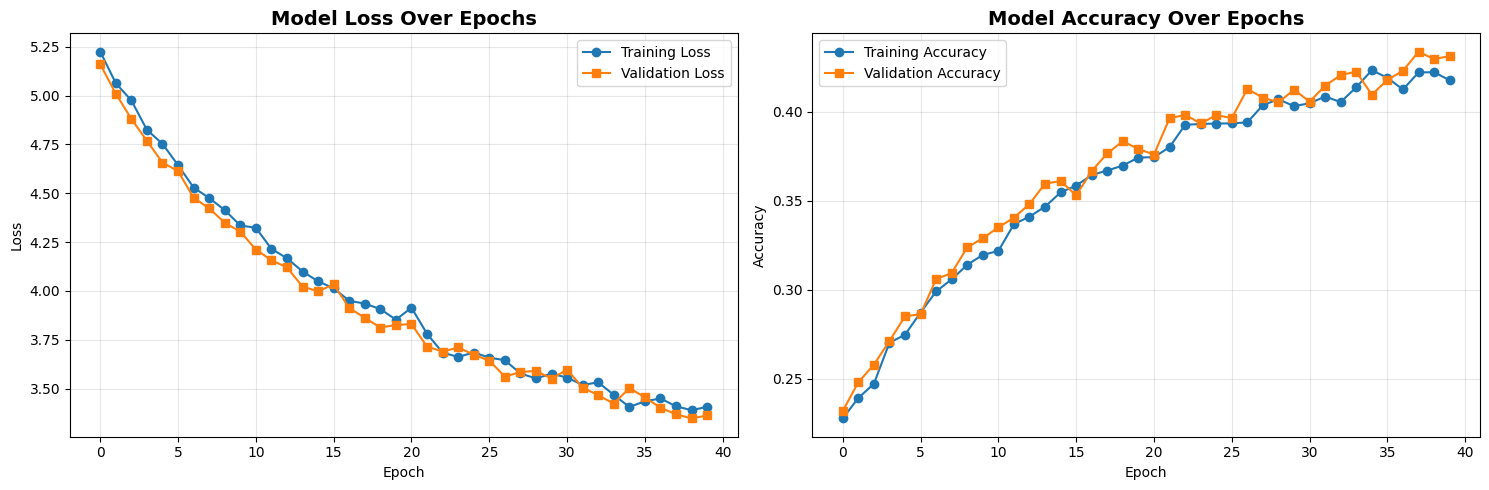


=== Training Summary ===
Final Training Loss: 3.4070
Final Training Accuracy: 0.4176
Final Validation Loss: 3.3624
Final Validation Accuracy: 0.4312
✅ No significant overfitting detected
Total Epochs Trained: 40


In [ ]:
# Plot training metrics (accuracy and loss) as a function of epochs
import matplotlib.pyplot as plt

# Get the training history from the model
history = transformer.history.history

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(history['loss'], label='Training Loss', marker='o')
if 'val_loss' in history:
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training and validation accuracy
ax2.plot(history['masked_accuracy'], label='Training Accuracy', marker='o')
if 'val_masked_accuracy' in history:
    ax2.plot(history['val_masked_accuracy'], label='Validation Accuracy', marker='s')
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig('assets/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Training Summary ===")
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['masked_accuracy'][-1]:.4f}")

if 'val_loss' in history:
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_masked_accuracy'][-1]:.4f}")
    
    # Check for overfitting by comparing training and validation loss
    # if the validation loss is significantly higher than training loss, this indicates overfitting
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    loss_diff = final_val_loss - final_train_loss
    
    if loss_diff > 0.1:
        print(f"⚠️  Potential overfitting detected (val_loss - train_loss = {loss_diff:.4f})")
    else:
        print("✅ No significant overfitting detected")

print(f"Total Epochs Trained: {len(history['loss'])}")

In [77]:
# since the model hasn't converged, run more epochs
transformer.fit(
    train_batches,
    epochs=20,              # Continue training for 20 more epochs
    steps_per_epoch=40,    # Maintain the same steps per epoch
    validation_data=val_batches,
    callbacks=[
        # Early Stopping: Stop training if validation accuracy stops improving
        tf.keras.callbacks.EarlyStopping(
            monitor='val_masked_accuracy',
            patience=5,
            restore_best_weights=True,
            mode='max'
        ),
    ]
)

all_histories.append(transformer.history)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 685ms/step - loss: 3.2421 - masked_accuracy: 0.4354 - val_loss: 3.3489 - val_masked_accuracy: 0.4364
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - loss: 3.2595 - masked_accuracy: 0.4325 - val_loss: 3.3641 - val_masked_accuracy: 0.4315
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 695ms/step - loss: 3.2997 - masked_accuracy: 0.4287 - val_loss: 3.4799 - val_masked_accuracy: 0.4106
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 707ms/step - loss: 3.2946 - masked_accuracy: 0.4252 - val_loss: 3.3921 - val_masked_accuracy: 0.4270
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 692ms/step - loss: 3.2633 - masked_accuracy: 0.4334 - val_loss: 3.3683 - val_masked_accuracy: 0.4276
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 705ms/step - loss: 3.3032 - masked_accuracy: 0.4237 - val_loss: 3.3517 - val_masked_accuracy: 0.4318


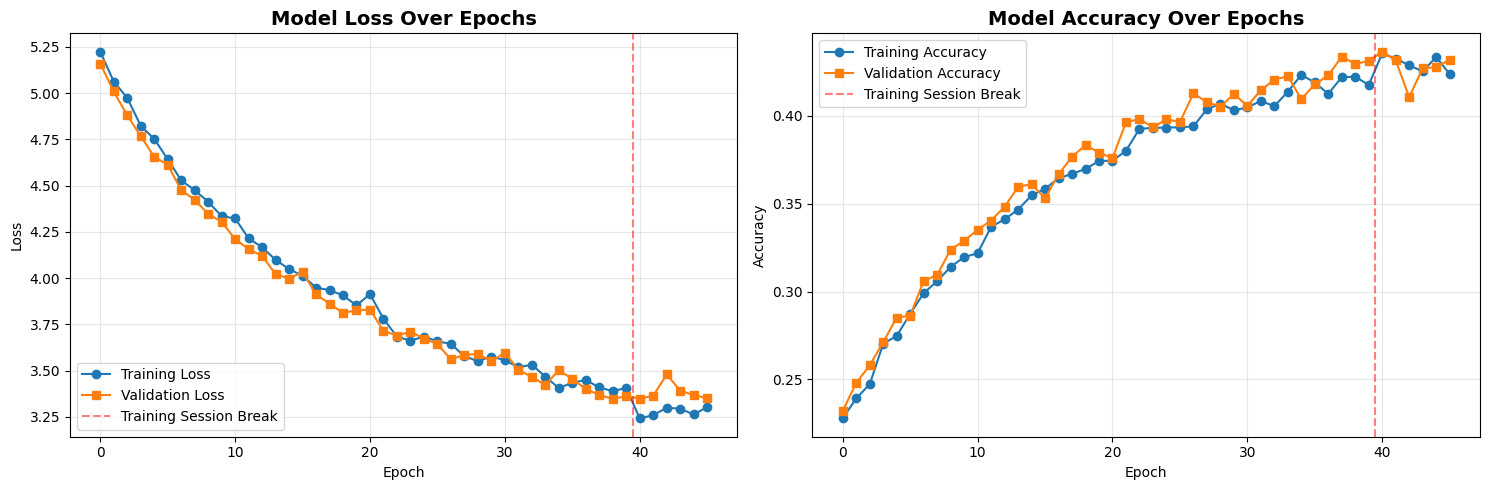


=== Combined Training Summary ===
Number of training sessions: 2
Final Training Loss: 3.3032
Final Training Accuracy: 0.4237
Final Validation Loss: 3.3517
Final Validation Accuracy: 0.4318
✅ No significant overfitting detected
Total Epochs Trained: 46

=== Training Session Breakdown ===
Session 1: 40 epochs
Session 2: 6 epochs


In [79]:
# Plot training metrics (accuracy and loss) as a function of epochs
import matplotlib.pyplot as plt

# Combine all training histories from all_histories
combined_history = {
    'loss': [],
    'masked_accuracy': [],
    'val_loss': [],
    'val_masked_accuracy': []
}

# Concatenate all histories in chronological order
for hist in all_histories:
    hist_dict = hist.history
    combined_history['loss'].extend(hist_dict['loss'])
    combined_history['masked_accuracy'].extend(hist_dict['masked_accuracy'])
    if 'val_loss' in hist_dict:
        combined_history['val_loss'].extend(hist_dict['val_loss'])
    if 'val_masked_accuracy' in hist_dict:
        combined_history['val_masked_accuracy'].extend(hist_dict['val_masked_accuracy'])

# Use combined history for plotting
history = combined_history

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(history['loss'], label='Training Loss', marker='o')
if 'val_loss' in history and len(history['val_loss']) > 0:
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training and validation accuracy
ax2.plot(history['masked_accuracy'], label='Training Accuracy', marker='o')
if 'val_masked_accuracy' in history and len(history['val_masked_accuracy']) > 0:
    ax2.plot(history['val_masked_accuracy'], label='Validation Accuracy', marker='s')
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add vertical lines to show training session boundaries
epoch_offset = 0
for i, hist in enumerate(all_histories[:-1]):  # Don't add line after last session
    epoch_offset += len(hist.history['loss'])
    ax1.axvline(x=epoch_offset - 0.5, color='red', linestyle='--', alpha=0.5, label='Training Session Break' if i == 0 else '')
    ax2.axvline(x=epoch_offset - 0.5, color='red', linestyle='--', alpha=0.5, label='Training Session Break' if i == 0 else '')

# Update legends to include session breaks if there are multiple sessions
if len(all_histories) > 1:
    ax1.legend()
    ax2.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('assets/training_metrics_combined.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Combined Training Summary ===")
print(f"Number of training sessions: {len(all_histories)}")
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['masked_accuracy'][-1]:.4f}")

if 'val_loss' in history and len(history['val_loss']) > 0:
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_masked_accuracy'][-1]:.4f}")
    
    # Check for overfitting
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    loss_diff = final_val_loss - final_train_loss
    
    if loss_diff > 0.1:
        print(f"⚠️  Potential overfitting detected (val_loss - train_loss = {loss_diff:.4f})")
    else:
        print("✅ No significant overfitting detected")

print(f"Total Epochs Trained: {len(history['loss'])}")

# Print session breakdown
print("\n=== Training Session Breakdown ===")
for i, hist in enumerate(all_histories):
    print(f"Session {i+1}: {len(hist.history['loss'])} epochs")

## Run inference 🚀🤖✨

You can now test the model by performing a translation. The following steps are used for inference: 🌍🤖✨

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input. 🧩🔢
* The decoder input is initialized to the `[START]` token. 🚦
* Calculate the padding masks and the look ahead masks. 🛡️👀
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention). 🔄✨
* Concatenate the predicted token to the decoder input and pass it to the decoder. ➕🔁
* In this approach, the decoder predicts the next token based on the previous tokens it predicted. ⏩🧠

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`). ⚡

Define the `Translator` class by subclassing `tf.Module`: 🏗️🤖

In [85]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    # Store the tokenizers and transformer model for use in translation
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence should be a tf.Tensor (Portuguese string)
    assert isinstance(sentence, tf.Tensor)
    # If the input is a scalar tensor, add a batch dimension
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # Tokenize the Portuguese sentence and pad to tensor
    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence  # Encoder input for the transformer

    # Prepare the initial decoder input: English [START] token
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]  # [START] token as tensor
    end = start_end[1][tf.newaxis]    # [END] token as tensor

    # Use tf.TensorArray for dynamic sequence generation in the loop
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)  # Write [START] token at position 0

    # Loop to generate each token in the output sequence
    for i in tf.range(max_length):
      # Stack and transpose output_array to shape (batch, seq_len)
      output = tf.transpose(output_array.stack())
      # Run the transformer to get predictions for the next token
      predictions = self.transformer([encoder_input, output], training=False)
      # Select the logits for the last generated token position
      predictions = predictions[:, -1:, :]  # Shape: (batch_size, 1, vocab_size)
      # Get the predicted token ID (highest probability)
      predicted_id = tf.argmax(predictions, axis=-1)
      # Append the predicted token to the output sequence
      output_array = output_array.write(i+1, predicted_id[0])
      # If the predicted token is [END], stop generation
      if predicted_id == end:
        break

    # Final output sequence: transpose to shape (batch, tokens)
    output = tf.transpose(output_array.stack())
    # Detokenize to get the translated English text
    text = tokenizers.en.detokenize(output)[0]  # Shape: ()
    # Lookup token strings for the output token IDs
    tokens = tokenizers.en.lookup(output)[0]

    # Attention weights: recalculate for the final output sequence
    # (tf.function tracing prevents direct access inside the loop)
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    # Return the translated text, token strings, and attention weights
    return text, tokens, attention_weights

In [86]:
import re

def smart_detokenize(tokenizer, token_ids):
    """Custom detokenization that handles contractions better."""
    # Get the raw detokenized text
    raw_text = tokenizer.detokenize(token_ids).numpy().decode('utf-8')
    
    # Fix contractions using regex patterns
    contraction_patterns = [
        (r"\b(\w+) n ' t\b", r"\1n't"),  # didn't, won't, etc.
        (r"\b(\w+) ' (m|re|ve|ll|d)\b", r"\1'\2"),  # I'm, you're, etc.
        (r"\b(\w+) ' s\b", r"\1's"),  # possessives and "is"
        (r" ' ", "'"),  # general apostrophe spacing
        # Additional patterns for common contractions
        (r"\bca n ' t\b", "can't"),  # Special case for "can't"
        (r"\bwo n ' t\b", "won't"),  # Special case for "won't"
    ]
    
    fixed_text = raw_text
    for pattern, replacement in contraction_patterns:
        fixed_text = re.sub(pattern, replacement, fixed_text, flags=re.IGNORECASE)
    
    return fixed_text

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient. ⚡🤖✨

Create an instance of this `Translator` class, and try it out a few times: 🌍🤖✨

In [87]:
# Create an instance of the Translator class for inference.
# - tokenizers: Contains the Portuguese and English tokenizers for encoding/decoding text.
# - transformer: The trained Transformer model for translation.
# The Translator class wraps the model and tokenizers, providing a convenient interface
# for translating Portuguese sentences to English using the trained Transformer.
translator = Translator(tokenizers, transformer)

In [88]:
def print_translation(sentence, tokens, ground_truth):
  # Print the input sentence (Portuguese or source language)
  print(f'{"Input:":15s}: {sentence}')

  # Print the predicted translation (English or target language)
  # - tokens: RaggedTensor containing token strings for the predicted output
  # - tokens.numpy(): Converts the RaggedTensor to a NumPy array of bytes
  # - .decode("utf-8"): Decodes the byte string to a regular Python string
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')

  # Print the ground truth translation (reference target sentence)
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [89]:
# Define the input sentence in Portuguese and its ground truth English translation.
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

# Use the Translator instance to translate the Portuguese sentence to English.
# - translator: An instance of the Translator class, which wraps the tokenizers and trained Transformer model.
# - tf.constant(sentence): Converts the input sentence to a TensorFlow tensor, as required by the Translator.
# - translated_text: The translated English sentence as a string.
# - translated_tokens: The tokenized output sequence (tokens) for the translated sentence.
# - attention_weights: The cross-attention weights from the Transformer, showing how each output token attends to the input tokens.
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# Print the input sentence, the predicted translation, and the ground truth translation.
# - print_translation: Utility function to display the input, prediction, and reference translation.
print_translation(sentence, translated_text, ground_truth)

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. Th

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we ' ve got to solve that we ' ve to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [90]:
# Define the input sentence in Portuguese and its ground truth English translation.
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

# Use the Translator instance to translate the Portuguese sentence to English.
# - translator: An instance of the Translator class, which wraps the tokenizers and trained Transformer model.
# - tf.constant(sentence): Converts the input sentence to a TensorFlow tensor, as required by the Translator.
# - translated_text: The translated English sentence as a string.
# - translated_tokens: The tokenized output sequence (tokens) for the translated sentence.
# - attention_weights: The cross-attention weights from the Transformer, showing how each output token attends to the input tokens.
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# Print the input sentence, the predicted translation, and the ground truth translation.
# - print_translation: Utility function to display the input, prediction, and reference translation.
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors to three - neighbors about this idea about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [91]:
# Define the input sentence in Portuguese and its ground truth English translation.
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

# Use the Translator instance to translate the Portuguese sentence to English.
# - translator: An instance of the Translator class, which wraps the tokenizers and trained Transformer model.
# - tf.constant(sentence): Converts the input sentence to a TensorFlow tensor, as required by the Translator.
# - translated_text: The translated English sentence as a string.
# - translated_tokens: The tokenized output sequence (tokens) for the translated sentence.
# - attention_weights: The cross-attention weights from the Transformer, showing how each output token attends to the input tokens.
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# Print the input sentence, the predicted translation, and the ground truth translation.
# - print_translation: Utility function to display the input, prediction, and reference translation.
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m very quickly going to share some of you with some of you that happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


2025-10-13 05:47:33.414332: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


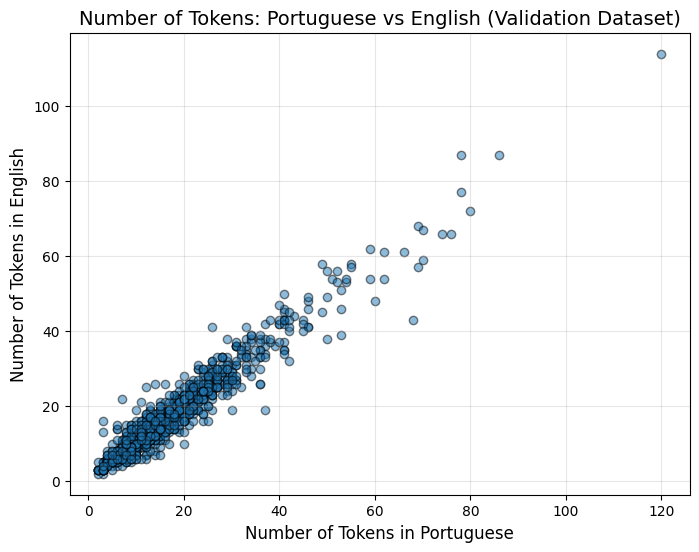

In [ ]:
# Extract the number of tokens in Portuguese and English sentences from the validation dataset
pt_lengths = []
en_lengths = []

for pt, en in val_examples:
    pt_lengths.append(len(pt.numpy().split()))
    en_lengths.append(len(en.numpy().split()))

# Plot the scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pt_lengths, en_lengths, alpha=0.5, edgecolor='k')
plt.title('Number of Tokens: Portuguese vs English (Validation Dataset)', fontsize=14)
plt.xlabel('Number of Tokens in Portuguese', fontsize=12)
plt.ylabel('Number of Tokens in English', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Starting comprehensive translation analysis...
Analyzing translation quality...
Processed 50 samples...


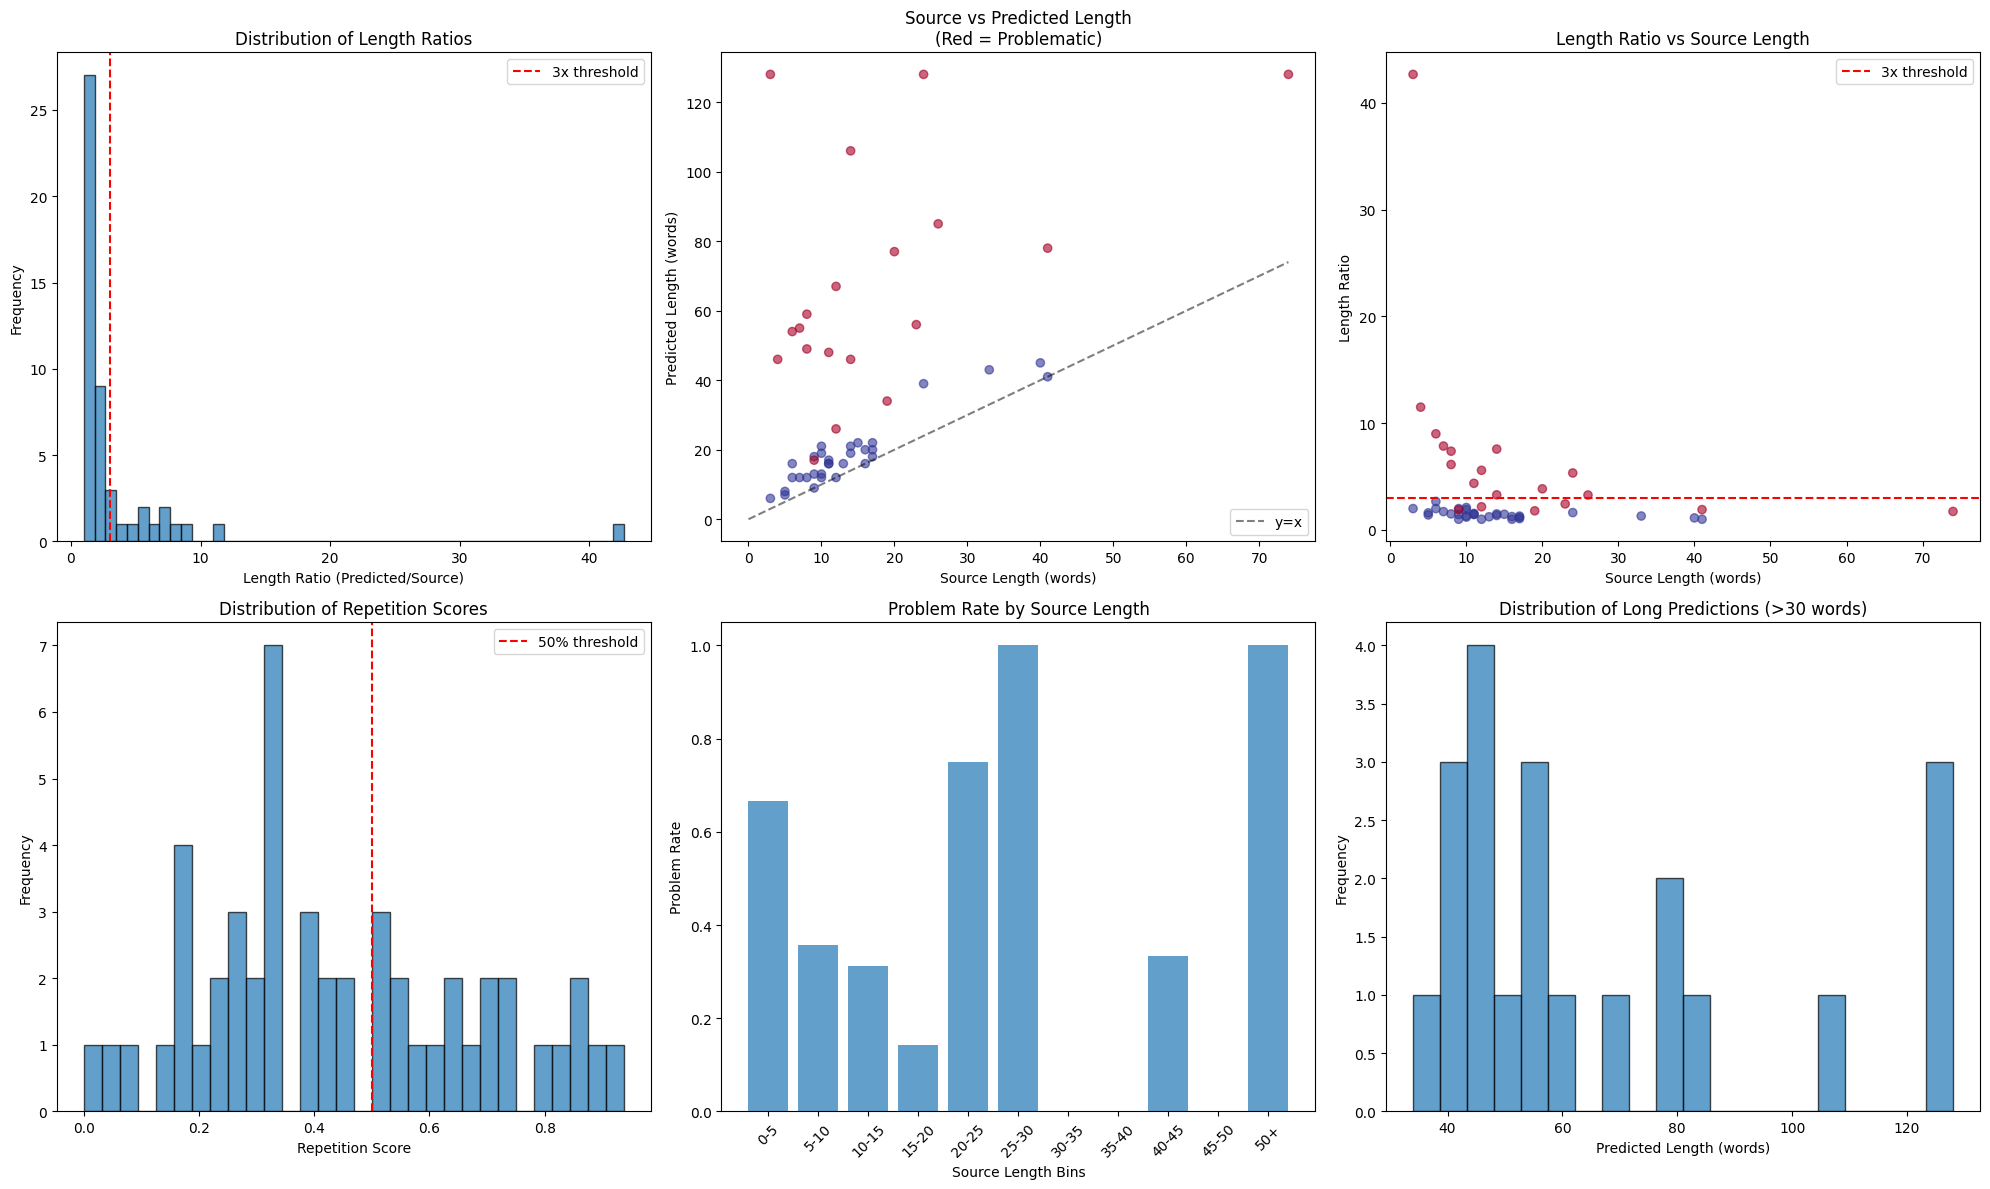


TRANSLATION QUALITY ANALYSIS RESULTS
Total samples analyzed: 50
Problematic translations: 19 (38.0%)

Length Statistics:
Average source length: 15.3 words
Average predicted length: 37.4 words
Average length ratio: 3.51

Problem Thresholds:
Translations >3x source length: 13 (26.0%)
High repetition (>50%): 19 (38.0%)
Very long predictions (>50 words): 12 (24.0%)

MOST PROBLEMATIC EXAMPLES

Example 1 (Length ratio: 42.7)
Source (3 words): e resultou .
Target (5 words): and , it worked .
Predicted (128 words): and and it ' and it ' s made . and it ' s done . and it ' and it ' s made . and it ' and it ' s made . and it ' s made . and it ' s made . and it ' s been . and it ' s . it ' s . it ' s . it ' s . it ' s . it ' s . it ' s . it ' s . it ' s . and it ' s . and it ' s . and it ' s . it ' s . and it ' s . and it ' s . it ' s . it ' s . and it
Repetition score: 0.94

Example 2 (Length ratio: 11.5)
Source (4 words): sem piada nenhuma .
Target (5 words): and without the humor .
Predicted 

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

def analyze_translation_quality(dataset, translator, max_samples=500):
    """
    Comprehensive analysis of translation quality issues including length explosion.
    """
    results = {
        'source_lengths': [],
        'target_lengths': [],
        'predicted_lengths': [],
        'length_ratios': [],
        'source_sentences': [],
        'target_sentences': [],
        'predicted_sentences': [],
        'repetition_scores': [],
        'meaningless_flags': []
    }
    
    print("Analyzing translation quality...")
    
    sample_count = 0
    for pt_sentence, en_sentence in dataset:
        if sample_count >= max_samples:
            break
            
        try:
            # Get model translation
            translated_text, _, _ = translator(tf.constant(pt_sentence.numpy()))
            predicted_sentence = translated_text.numpy().decode('utf-8')
            
            # Calculate lengths (in words)
            source_len = len(pt_sentence.numpy().decode('utf-8').split())
            target_len = len(en_sentence.numpy().decode('utf-8').split())
            predicted_len = len(predicted_sentence.split())
            
            # Calculate length ratio (predicted/source)
            length_ratio = predicted_len / source_len if source_len > 0 else 0
            
            # Calculate repetition score, which is the proportion of repeated words
            words = predicted_sentence.split()
            unique_words = set(words)
            repetition_score = 1 - (len(unique_words) / len(words)) if len(words) > 0 else 0
            
            # Flag potentially meaningless translations
            meaningless = (
                length_ratio > 3 or  # More than 3x longer than source
                repetition_score > 0.5 or  # More than 50% repeated words
                predicted_len > 50 or  # Extremely long predictions
                len(unique_words) < 3  # Very few unique words
            )
            
            # Store results
            results['source_lengths'].append(source_len)
            results['target_lengths'].append(target_len)
            results['predicted_lengths'].append(predicted_len)
            results['length_ratios'].append(length_ratio)
            results['source_sentences'].append(pt_sentence.numpy().decode('utf-8'))
            results['target_sentences'].append(en_sentence.numpy().decode('utf-8'))
            results['predicted_sentences'].append(predicted_sentence)
            results['repetition_scores'].append(repetition_score)
            results['meaningless_flags'].append(meaningless)
            
            sample_count += 1
            
            if sample_count % 50 == 0:
                print(f"Processed {sample_count} samples...")
                
        except Exception as e:
            print(f"Error processing sample {sample_count}: {e}")
            continue
    
    return results

# Run the analysis
print("Starting comprehensive translation analysis...")
analysis_results = analyze_translation_quality(val_examples, translator, max_samples=50)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Length ratio distribution
axes[0, 0].hist(analysis_results['length_ratios'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=3, color='red', linestyle='--', label='3x threshold')
axes[0, 0].set_xlabel('Length Ratio (Predicted/Source)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Length Ratios')
axes[0, 0].legend()

# 2. Source length vs predicted length scatter
scatter = axes[0, 1].scatter(analysis_results['source_lengths'], 
                           analysis_results['predicted_lengths'],
                           c=analysis_results['meaningless_flags'], 
                           cmap='RdYlBu_r', alpha=0.6)
axes[0, 1].plot([0, max(analysis_results['source_lengths'])], 
                [0, max(analysis_results['source_lengths'])], 
                'k--', alpha=0.5, label='y=x')
axes[0, 1].set_xlabel('Source Length (words)')
axes[0, 1].set_ylabel('Predicted Length (words)')
axes[0, 1].set_title('Source vs Predicted Length\n(Red = Problematic)')
axes[0, 1].legend()

# 3. Length ratio vs source length
axes[0, 2].scatter(analysis_results['source_lengths'], 
                   analysis_results['length_ratios'],
                   c=analysis_results['meaningless_flags'], 
                   cmap='RdYlBu_r', alpha=0.6)
axes[0, 2].axhline(y=3, color='red', linestyle='--', label='3x threshold')
axes[0, 2].set_xlabel('Source Length (words)')
axes[0, 2].set_ylabel('Length Ratio')
axes[0, 2].set_title('Length Ratio vs Source Length')
axes[0, 2].legend()

# 4. Repetition score distribution
axes[1, 0].hist(analysis_results['repetition_scores'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
axes[1, 0].set_xlabel('Repetition Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Repetition Scores')
axes[1, 0].legend()

# 5. Heatmap: Source length bins vs problems
source_bins = np.digitize(analysis_results['source_lengths'], bins=np.arange(0, 51, 5))
problem_by_bin = defaultdict(list)
for i, bin_idx in enumerate(source_bins):
    problem_by_bin[bin_idx].append(analysis_results['meaningless_flags'][i])

bin_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50+']
problem_rates = []
for i in range(1, len(bin_labels) + 1):
    if i in problem_by_bin:
        rate = np.mean(problem_by_bin[i])
        problem_rates.append(rate)
    else:
        problem_rates.append(0)

axes[1, 1].bar(range(len(bin_labels)), problem_rates, alpha=0.7)
axes[1, 1].set_xlabel('Source Length Bins')
axes[1, 1].set_ylabel('Problem Rate')
axes[1, 1].set_title('Problem Rate by Source Length')
axes[1, 1].set_xticks(range(len(bin_labels)))
axes[1, 1].set_xticklabels(bin_labels, rotation=45)

# 6. Length explosion examples count
long_predictions = [l for l in analysis_results['predicted_lengths'] if l > 30]
axes[1, 2].hist(long_predictions, bins=20, alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Predicted Length (words)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Distribution of Long Predictions (>30 words)')

plt.tight_layout()
plt.savefig('assets/translation_quality_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("TRANSLATION QUALITY ANALYSIS RESULTS")
print("="*60)

meaningless_count = sum(analysis_results['meaningless_flags'])
total_count = len(analysis_results['meaningless_flags'])

print(f"Total samples analyzed: {total_count}")
print(f"Problematic translations: {meaningless_count} ({meaningless_count/total_count*100:.1f}%)")

print(f"\nLength Statistics:")
print(f"Average source length: {np.mean(analysis_results['source_lengths']):.1f} words")
print(f"Average predicted length: {np.mean(analysis_results['predicted_lengths']):.1f} words")
print(f"Average length ratio: {np.mean(analysis_results['length_ratios']):.2f}")

print(f"\nProblem Thresholds:")
high_ratio_count = sum(1 for r in analysis_results['length_ratios'] if r > 3)
print(f"Translations >3x source length: {high_ratio_count} ({high_ratio_count/total_count*100:.1f}%)")

high_repetition_count = sum(1 for r in analysis_results['repetition_scores'] if r > 0.5)
print(f"High repetition (>50%): {high_repetition_count} ({high_repetition_count/total_count*100:.1f}%)")

very_long_count = sum(1 for l in analysis_results['predicted_lengths'] if l > 50)
print(f"Very long predictions (>50 words): {very_long_count} ({very_long_count/total_count*100:.1f}%)")

# Find problematic examples
print(f"\n" + "="*60)
print("MOST PROBLEMATIC EXAMPLES")
print("="*60)

# Sort by length ratio and show worst cases
sorted_indices = sorted(range(len(analysis_results['length_ratios'])), 
                       key=lambda i: analysis_results['length_ratios'][i], reverse=True)

for i, idx in enumerate(sorted_indices[:5]):
    print(f"\nExample {i+1} (Length ratio: {analysis_results['length_ratios'][idx]:.1f})")
    print(f"Source ({analysis_results['source_lengths'][idx]} words): {analysis_results['source_sentences'][idx]}")
    print(f"Target ({analysis_results['target_lengths'][idx]} words): {analysis_results['target_sentences'][idx]}")
    print(f"Predicted ({analysis_results['predicted_lengths'][idx]} words): {analysis_results['predicted_sentences'][idx]}")
    print(f"Repetition score: {analysis_results['repetition_scores'][idx]:.2f}")

# Analyze critical source length threshold
print(f"\n" + "="*60)
print("SOURCE LENGTH THRESHOLD ANALYSIS")
print("="*60)

for threshold in [10, 15, 20, 25, 30]:
    long_source_indices = [i for i, l in enumerate(analysis_results['source_lengths']) if l >= threshold]
    if long_source_indices:
        problem_rate = np.mean([analysis_results['meaningless_flags'][i] for i in long_source_indices])
        avg_ratio = np.mean([analysis_results['length_ratios'][i] for i in long_source_indices])
        print(f"Sources ≥{threshold} words: {len(long_source_indices)} samples, {problem_rate*100:.1f}% problematic, avg ratio: {avg_ratio:.2f}")

### Model Struggles with Contractions and Repetition

The model appears to struggle with words that contain abbreviations or contractions, such as "don't", "can't", "didn't", etc. These words are often tokenized into multiple subwords or tokens, which can lead to incorrect or incomplete translations. For example:

- "don't" might be tokenized into "do" and "n't".
- "can't" might be tokenized into "ca" and "n't".

This can cause the model to lose the semantic meaning of the contraction, resulting in translations that are either grammatically incorrect or fail to capture the intended meaning. Improving the handling of such cases may require:

1. **Better Tokenization**: Using a tokenizer that preserves contractions as single tokens.
2. **Data Augmentation**: Including more examples of sentences with contractions in the training dataset.
3. **Post-Processing**: Adding a post-processing step to correct common issues with contractions in the output.

Addressing this limitation is crucial for improving the model's performance on conversational or informal text, where contractions are frequently used.

In [94]:
# Test sentences with contractions
test_contractions = [
    "eu não posso fazer isso",  # "I can't do this"
    "ele não vai vir hoje",     # "He won't come today"  
    "nós não sabemos a resposta", # "We don't know the answer"
    "ela não tem tempo"         # "She doesn't have time"
]

print("Testing contraction handling:")
print("=" * 50)

for pt_sentence in test_contractions:
    translated_text, _, _ = translator(tf.constant(pt_sentence))
    translation = translated_text.numpy().decode('utf-8')
    print(f"Portuguese: {pt_sentence}")
    print(f"English:    {translation}")
    print()

Testing contraction handling:


/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. Th

Portuguese: eu não posso fazer isso
English:    i can not do n ' t can not do that that that that i can not do that that i can not do that that that that , i can not do n ' t can not do n ' t can not to do that that that , i can not to do that that that that that that that that that that that that that that that that that that that that that that that is not to do that that that that that ' sha that that that that that that ' sha that ' s that ' s that ' s that ' s that ' s not to do that that ' s because i can not to do that

Portuguese: ele não vai vir hoje
English:    he ' s not going to happen today ' s today ' s today ' s today ' s going to happen today ' and it ' s not going to happen today ' s going to not going to not going to not going to happen today ' s today ' s today ' s today ' s today ' s today ' s today ' s today ' s today ' s today ' s today ' s today ' s going to happen today ' s going to be today ' s today ' s going to be today ' s going to be today ' s going to be t

Analyzing relationship between contractions and repetition...


/tmp/ipykernel_3514567/475229492.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_to_plot, labels=['No contractions', 'Has contractions'])


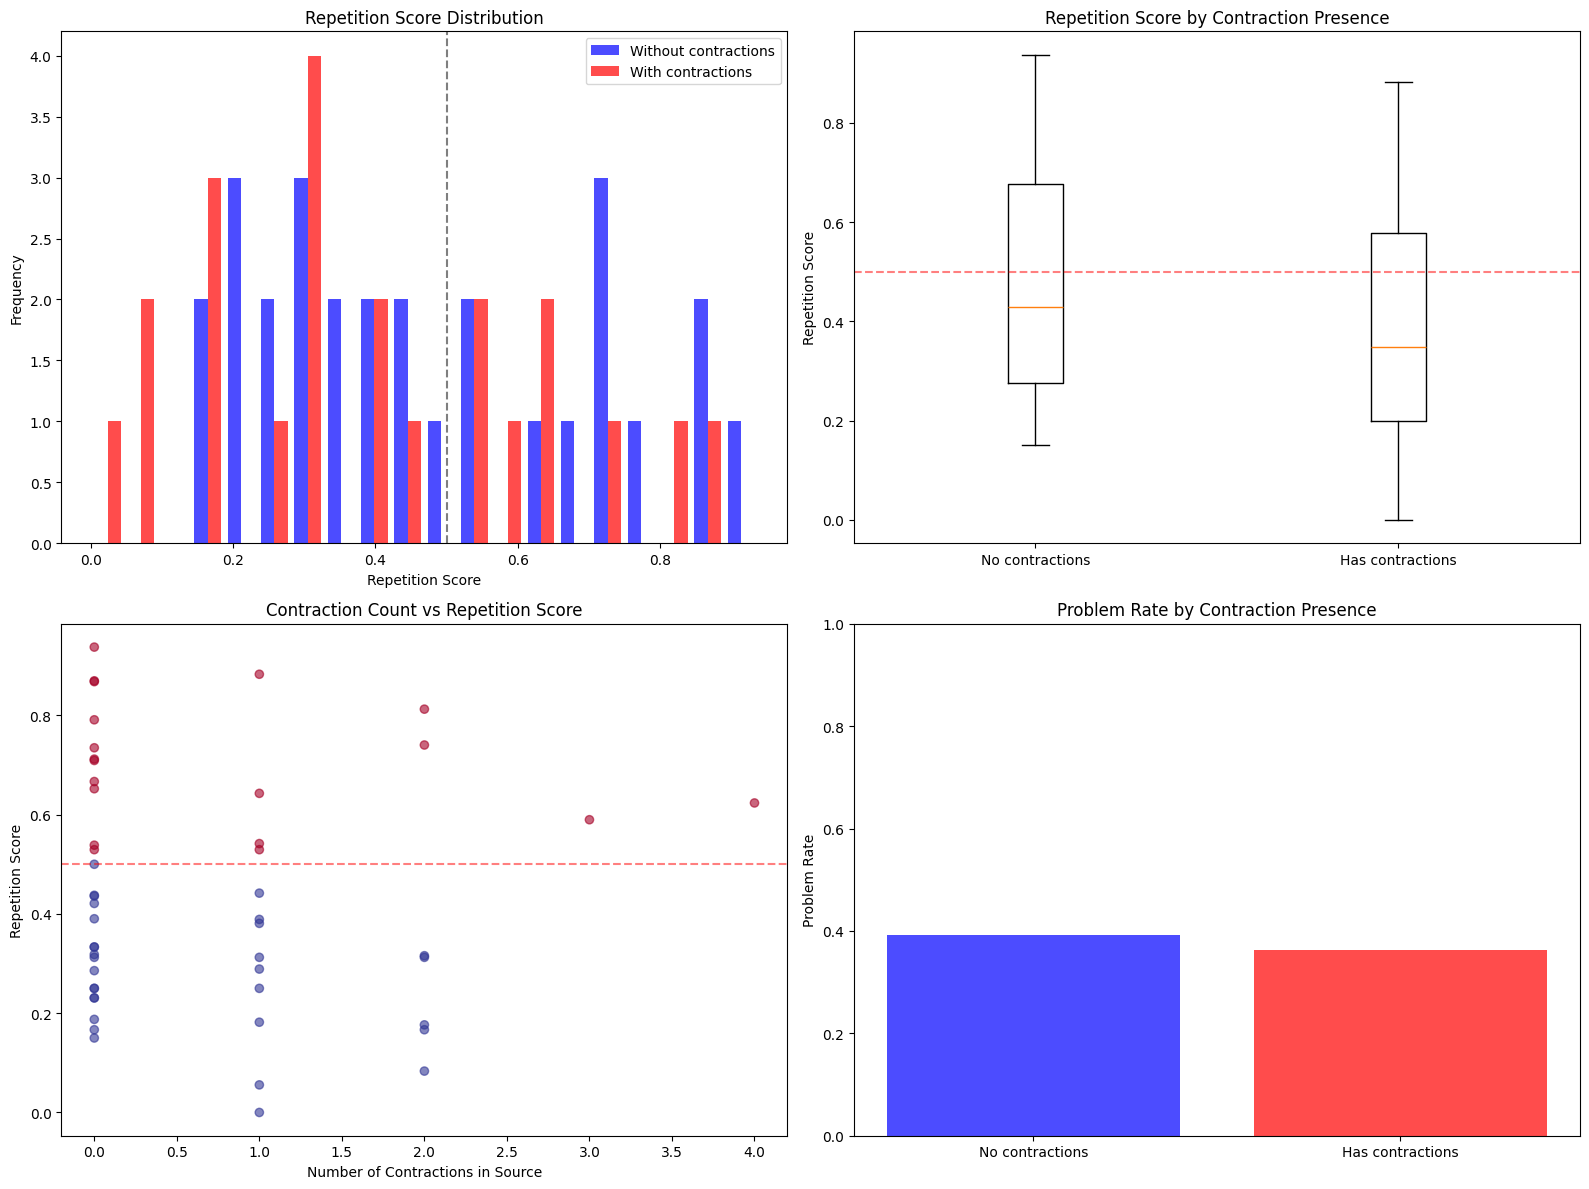


CONTRACTION-REPETITION RELATIONSHIP ANALYSIS
Total sentences analyzed: 50
Sentences with contractions: 22 (44.0%)
Sentences without contractions: 28 (56.0%)

Mean repetition score:
  With contractions: 0.396
  Without contractions: 0.473
  Difference: -0.077

High repetition (>0.5) analysis:
  With contractions: 8/22 (36.4%)
  Without contractions: 11/28 (39.3%)

Problem rates:
  With contractions: 36.4%
  Without contractions: 39.3%

WORST REPETITION EXAMPLES WITH CONTRACTIONS

Example 1 (Repetition: 0.883, Contractions: 1)
Source: `` então e se nós começássemos a usar a teoria dos cinco sentidos em todos os nossos `` '' designs '' '' ? ''
Predicted: ` ` and then if we ' re going to use the theory of the whole of our ` ` ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ` ` ` ` ` ` ` ` ` ' ' ` ` ` ` ' ` ` ` ` ` ' ` ` ` ` ` ' ` '
Problematic: True

Example 2 (Repetition: 0.812, Co

In [96]:
def analyze_contraction_repetition_relationship(analysis_results):
    """
    Analyze the relationship between contractions in source sentences and repetition in translations.
    """
    import re
    
    # Define contraction patterns to detect in Portuguese
    portuguese_contraction_patterns = [
        r'\bnão\b',          # "não" (not) - often leads to contractions like "don't", "can't"
        r'\bdo\b',           # "do" - can lead to contractions  
        r'\bda\b',           # "da" - can lead to contractions
        r'\bdos\b',          # "dos" - can lead to contractions
        r'\bdas\b',          # "das" - can lead to contractions
        r'\bno\b',           # "no" - can lead to contractions
        r'\bna\b',           # "na" - can lead to contractions
        r'\bnos\b',          # "nos" - can lead to contractions
        r'\bnas\b',          # "nas" - can lead to contractions
        r'\bpelo\b',         # "pelo" - can lead to contractions
        r'\bpela\b',         # "pela" - can lead to contractions
    ]
    
    # Analyze each sentence
    contraction_analysis = {
        'has_contraction': [],
        'contraction_count': [],
        'repetition_score': [],
        'source_sentence': [],
        'predicted_sentence': [],
        'is_problematic': []
    }
    
    for i, source in enumerate(analysis_results['source_sentences']):
        # Count contractions in source
        contraction_count = 0
        for pattern in portuguese_contraction_patterns:
            contraction_count += len(re.findall(pattern, source.lower()))
        
        has_contraction = contraction_count > 0
        
        contraction_analysis['has_contraction'].append(has_contraction)
        contraction_analysis['contraction_count'].append(contraction_count)
        contraction_analysis['repetition_score'].append(analysis_results['repetition_scores'][i])
        contraction_analysis['source_sentence'].append(source)
        contraction_analysis['predicted_sentence'].append(analysis_results['predicted_sentences'][i])
        contraction_analysis['is_problematic'].append(analysis_results['meaningless_flags'][i])
    
    return contraction_analysis

def plot_contraction_repetition_analysis(contraction_analysis):
    """
    Create visualizations showing the relationship between contractions and repetition.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Repetition scores: with vs without contractions
    with_contractions = [score for i, score in enumerate(contraction_analysis['repetition_score']) 
                        if contraction_analysis['has_contraction'][i]]
    without_contractions = [score for i, score in enumerate(contraction_analysis['repetition_score']) 
                           if not contraction_analysis['has_contraction'][i]]
    
    axes[0, 0].hist([without_contractions, with_contractions], 
                    bins=20, alpha=0.7, label=['Without contractions', 'With contractions'],
                    color=['blue', 'red'])
    axes[0, 0].set_xlabel('Repetition Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Repetition Score Distribution')
    axes[0, 0].legend()
    axes[0, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Problem threshold')
    
    # 2. Box plot comparison
    data_to_plot = [without_contractions, with_contractions]
    axes[0, 1].boxplot(data_to_plot, labels=['No contractions', 'Has contractions'])
    axes[0, 1].set_ylabel('Repetition Score')
    axes[0, 1].set_title('Repetition Score by Contraction Presence')
    axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 3. Scatter: Contraction count vs Repetition score
    axes[1, 0].scatter(contraction_analysis['contraction_count'], 
                      contraction_analysis['repetition_score'],
                      alpha=0.6, c=contraction_analysis['is_problematic'], 
                      cmap='RdYlBu_r')
    axes[1, 0].set_xlabel('Number of Contractions in Source')
    axes[1, 0].set_ylabel('Repetition Score')
    axes[1, 0].set_title('Contraction Count vs Repetition Score')
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 4. Problem rate by contraction presence
    with_contr_problems = [prob for i, prob in enumerate(contraction_analysis['is_problematic']) 
                          if contraction_analysis['has_contraction'][i]]
    without_contr_problems = [prob for i, prob in enumerate(contraction_analysis['is_problematic']) 
                             if not contraction_analysis['has_contraction'][i]]
    
    problem_rates = [
        np.mean(without_contr_problems) if without_contr_problems else 0,
        np.mean(with_contr_problems) if with_contr_problems else 0
    ]
    
    axes[1, 1].bar(['No contractions', 'Has contractions'], problem_rates, 
                   color=['blue', 'red'], alpha=0.7)
    axes[1, 1].set_ylabel('Problem Rate')
    axes[1, 1].set_title('Problem Rate by Contraction Presence')
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('assets/contraction_repetition_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return problem_rates

# Run the analysis
print("Analyzing relationship between contractions and repetition...")
contraction_analysis = analyze_contraction_repetition_relationship(analysis_results)

# Create visualizations
problem_rates = plot_contraction_repetition_analysis(contraction_analysis)

# Print detailed statistics
print("\n" + "="*60)
print("CONTRACTION-REPETITION RELATIONSHIP ANALYSIS")
print("="*60)

total_sentences = len(contraction_analysis['has_contraction'])
with_contractions = sum(contraction_analysis['has_contraction'])
without_contractions = total_sentences - with_contractions

print(f"Total sentences analyzed: {total_sentences}")
print(f"Sentences with contractions: {with_contractions} ({with_contractions/total_sentences*100:.1f}%)")
print(f"Sentences without contractions: {without_contractions} ({without_contractions/total_sentences*100:.1f}%)")

# Calculate mean repetition scores
with_contr_scores = [score for i, score in enumerate(contraction_analysis['repetition_score']) 
                    if contraction_analysis['has_contraction'][i]]
without_contr_scores = [score for i, score in enumerate(contraction_analysis['repetition_score']) 
                       if not contraction_analysis['has_contraction'][i]]

if with_contr_scores and without_contr_scores:
    print(f"\nMean repetition score:")
    print(f"  With contractions: {np.mean(with_contr_scores):.3f}")
    print(f"  Without contractions: {np.mean(without_contr_scores):.3f}")
    print(f"  Difference: {np.mean(with_contr_scores) - np.mean(without_contr_scores):.3f}")

# High repetition analysis
print(f"\nHigh repetition (>0.5) analysis:")
high_rep_with_contr = sum(1 for i, score in enumerate(contraction_analysis['repetition_score']) 
                         if score > 0.5 and contraction_analysis['has_contraction'][i])
high_rep_without_contr = sum(1 for i, score in enumerate(contraction_analysis['repetition_score']) 
                            if score > 0.5 and not contraction_analysis['has_contraction'][i])

if with_contractions > 0:
    print(f"  With contractions: {high_rep_with_contr}/{with_contractions} ({high_rep_with_contr/with_contractions*100:.1f}%)")
if without_contractions > 0:
    print(f"  Without contractions: {high_rep_without_contr}/{without_contractions} ({high_rep_without_contr/without_contractions*100:.1f}%)")

print(f"\nProblem rates:")
print(f"  With contractions: {problem_rates[1]*100:.1f}%")
print(f"  Without contractions: {problem_rates[0]*100:.1f}%")

# Show worst examples with contractions
print(f"\n" + "="*60)
print("WORST REPETITION EXAMPLES WITH CONTRACTIONS")
print("="*60)

# Find sentences with contractions and high repetition
high_rep_contraction_examples = []
for i in range(len(contraction_analysis['has_contraction'])):
    if (contraction_analysis['has_contraction'][i] and 
        contraction_analysis['repetition_score'][i] > 0.3):  # Lower threshold to see more examples
        high_rep_contraction_examples.append({
            'index': i,
            'repetition_score': contraction_analysis['repetition_score'][i],
            'contraction_count': contraction_analysis['contraction_count'][i],
            'source': contraction_analysis['source_sentence'][i],
            'predicted': contraction_analysis['predicted_sentence'][i],
            'is_problematic': contraction_analysis['is_problematic'][i]
        })

# Sort by repetition score
high_rep_contraction_examples.sort(key=lambda x: x['repetition_score'], reverse=True)

for i, example in enumerate(high_rep_contraction_examples[:5]):
    print(f"\nExample {i+1} (Repetition: {example['repetition_score']:.3f}, Contractions: {example['contraction_count']})")
    print(f"Source: {example['source']}")
    print(f"Predicted: {example['predicted']}")
    print(f"Problematic: {example['is_problematic']}")

## Create attention plots 🎯✨

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model. 🎯✨

For example:

In [ ]:
# Define the input sentence in Portuguese and its ground truth English translation.
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

# Use the Translator instance to translate the Portuguese sentence to English.
# - translator: An instance of the Translator class, which wraps the tokenizers and trained Transformer model.
# - tf.constant(sentence): Converts the input sentence to a TensorFlow tensor, as required by the Translator.
# - translated_text: The translated English sentence as a string.
# - translated_tokens: The tokenized output sequence (tokens) for the translated sentence.
# - attention_weights: The cross-attention weights from the Transformer, showing how each output token attends to the input tokens.
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# Print the input sentence, the predicted translation, and the ground truth translation.
# - print_translation: Utility function to display the input, prediction, and reference translation.
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : spacecraft staying yale stopped next stopped ethical calculation spacecraft limestone stopped presented poorest thank mistakes coworkers calculation hard stopped territory territory frank calculation territory mechanics thank prey prey prey slowing slowing slowing stopped roll roll detail slowinghave muslims detail next mechanics mechanics mechanics mechanicsboxs lack lackard next heads next early sons towns towns towns towns stopped next engineer engineer engineer engineer engineer engineer engineer engineer engineer employees engineer employeesuizuiz right obtained degreesym disconnectedssing mouse employeesuiz easily employeess charity narrator boil promise promise courses theirs narrator eveningtions absurd absurd absurd furthers narrator feeling furtherymtionstionstionstions exists dinner institution sendsuizuiztions feelingurable sonsrick argue hold sorts move rangelize
Ground truth   : this is the first book i

Create a function that plots the attention when a token is generated:

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # Remove the <START> token from the translated output tokens for plotting.
  translated_tokens = translated_tokens[1:]

  # Get the current matplotlib axis for plotting.
  ax = plt.gca()
  # Display the attention matrix as a heatmap.
  ax.matshow(attention)
  # Set the x-axis ticks to match the number of input tokens.
  ax.set_xticks(range(len(in_tokens)))
  # Set the y-axis ticks to match the number of translated tokens (excluding <START>).
  ax.set_yticks(range(len(translated_tokens)))

  # Decode the input tokens from bytes to strings for labeling the x-axis.
  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels for readability.

  # Decode the translated tokens from bytes to strings for labeling the y-axis.
  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0  # Select which attention head to visualize (0-based index)

# The attention_weights tensor has shape (batch_size, num_heads, seq_len_q, seq_len_k)
# - batch_size: Number of sequences in the batch (usually 1 for inference/visualization)
# - num_heads: Number of attention heads in the decoder
# - seq_len_q: Length of the query sequence (target/output tokens)
# - seq_len_k: Length of the key sequence (source/input tokens)

# Remove the batch dimension since we're visualizing a single example
attention_heads = tf.squeeze(attention_weights, 0)  # Shape: (num_heads, seq_len_q, seq_len_k)

# Select the attention matrix for the desired head
attention = attention_heads[head]  # Shape: (seq_len_q, seq_len_k)

# Print the shape of the selected attention matrix for verification
attention.shape  # Should be (seq_len_q, seq_len_k)

TensorShape([128, 11])

These are the input (Portuguese) tokens:

In [ ]:
# Convert the input sentence (Portuguese) to a tensor with batch dimension.
in_tokens = tf.convert_to_tensor([sentence])

# Tokenize the input sentence using the Portuguese tokenizer.
# This converts the string to a sequence of token IDs.
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()

# Lookup the string representation of each token ID.
# This converts the token IDs back to their corresponding token strings.
in_tokens = tokenizers.pt.lookup(in_tokens)[0]

# Display the list of token strings for the input sentence.
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [ ]:
translated_tokens

<tf.Tensor: shape=(129,), dtype=string, numpy=
array([b'[START]', b'spacecraft', b'staying', b'yale', b'stopped',
       b'next', b'stopped', b'ethical', b'calculation', b'spacecraft',
       b'limestone', b'stopped', b'presented', b'poorest', b'thank',
       b'mistakes', b'coworkers', b'calculation', b'hard', b'stopped',
       b'territory', b'territory', b'frank', b'calculation', b'territory',
       b'mechanics', b'thank', b'prey', b'prey', b'prey', b'slowing',
       b'slowing', b'slowing', b'stopped', b'roll', b'roll', b'detail',
       b'slowing', b'##have', b'muslims', b'detail', b'next',
       b'mechanics', b'mechanics', b'mechanics', b'mechanics', b'##box',
       b'##s', b'lack', b'lack', b'##ard', b'next', b'heads', b'next',
       b'early', b'sons', b'towns', b'towns', b'towns', b'towns',
       b'stopped', b'next', b'engineer', b'engineer', b'engineer',
       b'engineer', b'engineer', b'engineer', b'engineer', b'engineer',
       b'engineer', b'employees', b'engineer', 

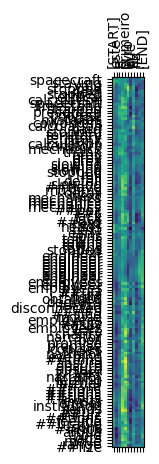

In [ ]:
# Plot the attention heatmap for a single attention head.
# This function visualizes how each output token attends to each input token during translation.
# Arguments:
#   in_tokens: Tensor of input (source language) tokens as strings.
#   translated_tokens: Tensor of output (target language) tokens as strings.
#   attention: 2D attention matrix (shape: [output_tokens, input_tokens]) for a single attention head.

plot_attention_head(in_tokens, translated_tokens, attention, filename='attention_head_0.png')

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads, filename=None):
  # Convert the input sentence (string) to a tensor with batch dimension
  in_tokens = tf.convert_to_tensor([sentence])
  # Tokenize the input sentence using the Portuguese tokenizer and pad to tensor
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  # Lookup the string representation of each token ID for display
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  # Create a matplotlib figure with a specified size to hold all attention head plots
  fig = plt.figure(figsize=(16, 8))

  # Iterate over each attention head and its index
  for h, head in enumerate(attention_heads):
    # Add a subplot for each attention head (2 rows, 4 columns, index h+1)
    ax = fig.add_subplot(2, 4, h+1)

    # Plot the attention heatmap for this head using the helper function
    plot_attention_head(in_tokens, translated_tokens, head)

    # Label the x-axis with the head number for clarity
    ax.set_xlabel(f'Head {h+1}')

  # Adjust subplot layout to prevent overlap and display the figure
  plt.tight_layout()
  plt.show()
  plt.savefig(filename)

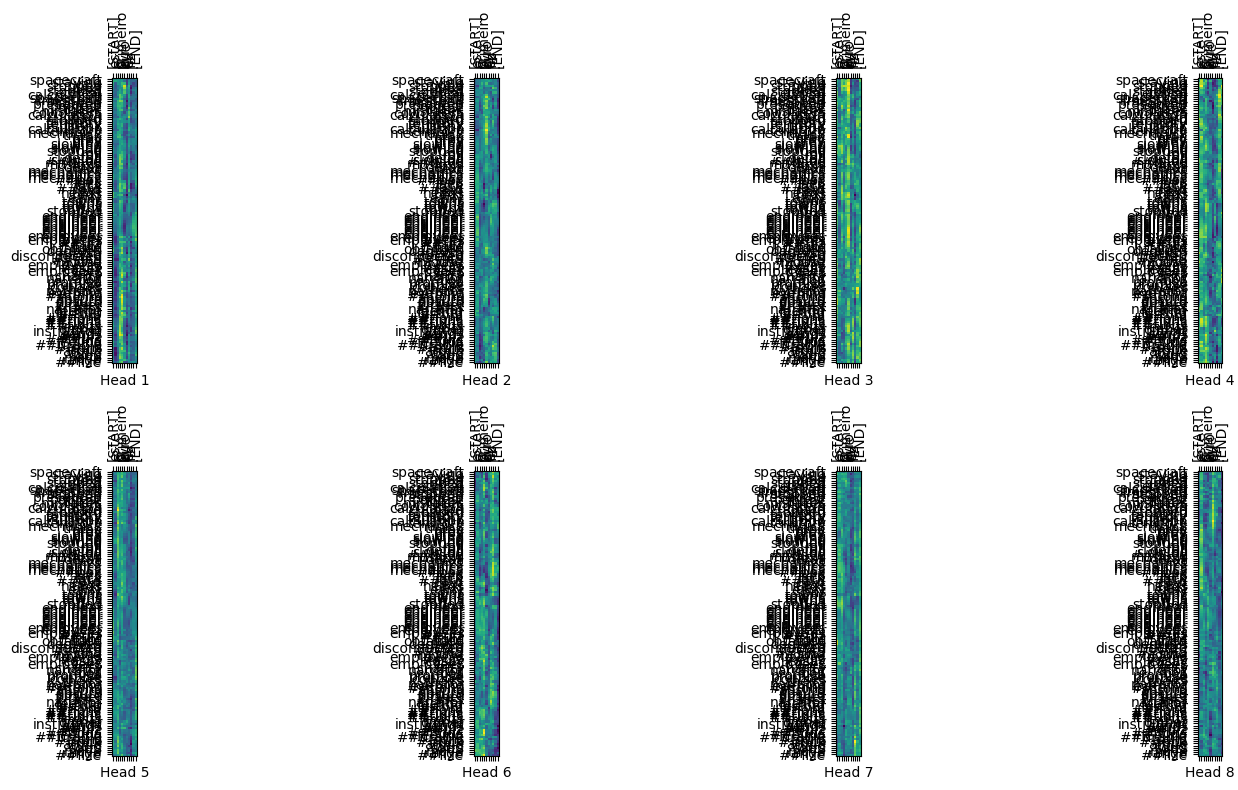

In [ ]:
# Plot the attention weights for all attention heads for a given input sentence and its translation.
# Arguments:
#   sentence: The input sentence (string) in the source language (Portuguese).
#   translated_tokens: The output tokens (tensor) from the translation (target language, English).
#   attention_weights[0]: The attention weights for the first example in the batch.
#     - Shape: (num_heads, output_tokens, input_tokens)
#     - Each head's attention matrix shows how each output token attends to each input token.


plot_attention_weights(
    sentence,            # The input sentence to be translated and visualized.
    translated_tokens,   # The tokens of the translated output sentence.
    attention_weights[0] # The attention weights for the first example (all heads).
    'attention_all_heads.png'
)

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. Th

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : spacecraft staying yale stopped ship stopped ethical calculation spacecraft limestone stopped presented poorest thank mistakes thank stopped thank stopped territory territory territory frank patterns muslims up stopped thank yale inform roll roll roll roll rollbbie rollhave muslims next next mechanics mechanics mechanics mechanicsboxs lacks lack yale right towns towns towns towns towns towns towns stopped next engineer engineer engineer engineer engineer engineer engineer engineer engineer employees engineer employeesuiz exists right obtained degreesym disconnectedssing mouse employeesuiz easily employeess analysis vote boil promise promise courses theirs narrator eveningtions absurd pooresturable obesitys narrator feeling furtherymtionstionstionstions exists dinner existsuiz domesticuiztions feelingurable sonsrick argue hold sorts move range citizen
Ground truth   : I read about triceratops in the encyclopedia.

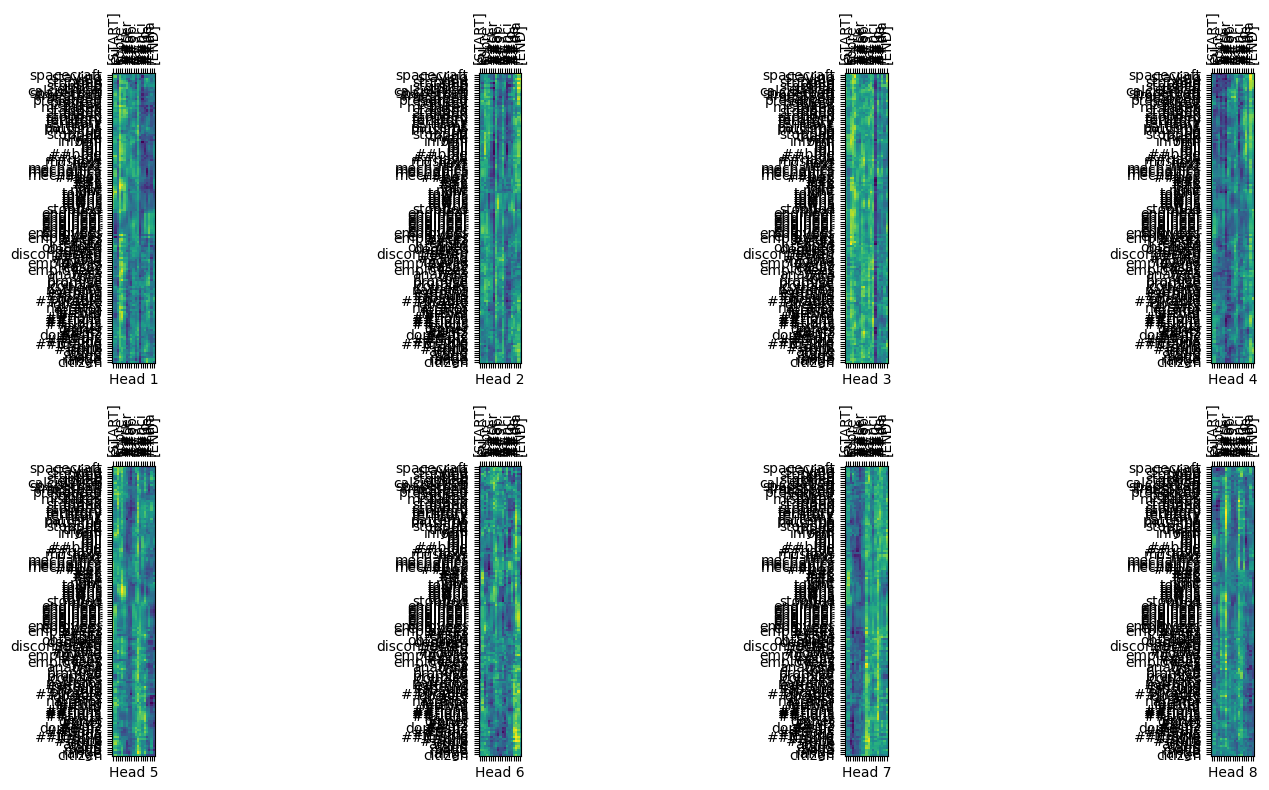

In [ ]:
# Define a Portuguese input sentence and its English ground truth translation.
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

# Use the Translator instance to translate the Portuguese sentence to English.
# - translator: An instance of the Translator class, which wraps the tokenizers and trained Transformer model.
# - tf.constant(sentence): Converts the input sentence to a TensorFlow tensor, as required by the Translator.
# - translated_text: The translated English sentence as a string.
# - translated_tokens: The tokenized output sequence (tokens) for the translated sentence.
# - attention_weights: The cross-attention weights from the Transformer, showing how each output token attends to the input tokens.
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# Print the input sentence, the predicted translation, and the ground truth translation.
# - print_translation: Utility function to display the input, prediction, and reference translation.
print_translation(sentence, translated_text, ground_truth)

# Visualize the attention weights for all heads for this translation.
# - plot_attention_weights: Plots the attention heatmaps for each attention head.
# - sentence: The input sentence (Portuguese).
# - translated_tokens: The output tokens (English translation).
# - attention_weights[0]: The attention weights for the first example in the batch (all heads).
plot_attention_weights(sentence, translated_tokens, attention_weights[0], filename='attention_triceratops.png')

## Export the model 📦✨

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model). 📦✨

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method: 🤖📝

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    # Store the Translator instance, which wraps the tokenizers and trained Transformer model.
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    # Run the translation for the input sentence using the Translator.
    (result, tokens, attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)
    
    # The result already uses smart_detokenize, so return it directly
    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [ ]:
# Wrap the existing Translator instance in the ExportTranslator class for exporting as a SavedModel.
# - ExportTranslator: A tf.Module subclass that provides a tf.function for inference.
#   This allows you to export the translation model for serving or deployment.
# - translator: The Translator instance, which contains the tokenizers and trained Transformer model.
# After this assignment, 'translator' refers to the ExportTranslator instance,
# which can be used for inference and exporting the model.
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [ ]:
# Translate a Portuguese sentence to English using the exported Translator model.
# - translator: An instance of ExportTranslator, which wraps the trained Translator and Transformer model.
# - The input is a Portuguese sentence as a string.
# - The output is a TensorFlow string tensor containing the translated English sentence.
# - .numpy(): Converts the output tensor to a NumPy array (or Python string) for display.
translator('este é o primeiro livro que eu fiz.').numpy()

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a 

b'spacecraft staying yale stopped next stopped ethical calculation spacecraft limestone stopped presented poorest thank mistakes coworkers calculation hard stopped territory territory frank calculation territory mechanics thank prey prey prey slowing slowing slowing stopped roll roll detail slowinghave muslims detail next mechanics mechanics mechanics mechanicsboxs lack lackard next heads next early sons towns towns towns towns stopped next engineer engineer engineer engineer engineer engineer engineer engineer engineer employees engineer employeesuizuiz right obtained degreesym disconnectedssing mouse employeesuiz easily employeess charity narrator boil promise promise courses theirs narrator eveningtions absurd absurd absurd furthers narrator feeling furtherymtionstionstionstions exists dinner institution sendsuizuiztions feelingurable sonsrick argue hold sorts move rangelize'

In [ ]:
import os

# Directory where the model will be saved
SAVE_DIR = "artifacts"

# Name for the exported model
model_name = "translator"

# Full path to save the model (artifacts/translator)
MODEL_PATH = os.path.join(SAVE_DIR, model_name)

# Export the translator model as a TensorFlow SavedModel.
# - translator: The ExportTranslator instance, which wraps the trained Translator and Transformer model.
# - export_dir: The directory path where the SavedModel will be stored.
# This will create the directory and save all necessary files for loading and serving the model later.
tf.saved_model.save(translator, export_dir=MODEL_PATH)

/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/zkhechadoorian/Spanish_and_Portuguese_Translator/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a 

INFO:tensorflow:Assets written to: artifacts/translator/assets


INFO:tensorflow:Assets written to: artifacts/translator/assets


In [ ]:
# Load the exported TensorFlow SavedModel from disk.
# - MODEL_PATH: The directory path where the SavedModel was saved (e.g., "artifacts/translator").
# - tf.saved_model.load: Loads the model and returns a callable object for inference.
#   This object can be used to perform translation using the exported model.
#   The loaded model will have the same behavior as the original ExportTranslator instance.
reloaded = tf.saved_model.load(MODEL_PATH)

In [ ]:
# Use the reloaded SavedModel to translate a Portuguese sentence to English.
# - reloaded: This is the loaded TensorFlow SavedModel, which wraps the ExportTranslator module.
# - The input is a Portuguese sentence as a string.
# - The output is a TensorFlow string tensor containing the translated English sentence.
# - .numpy(): Converts the output tensor to a NumPy array (or Python string) for display.
# This demonstrates that the exported and reloaded model produces the same deterministic output as the original model.
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'spacecraft staying yale stopped next stopped ethical calculation spacecraft limestone stopped presented poorest thank mistakes coworkers calculation hard stopped territory territory frank calculation territory mechanics thank prey prey prey slowing slowing slowing stopped roll roll detail slowinghave muslims detail next mechanics mechanics mechanics mechanicsboxs lack lackard next heads next early sons towns towns towns towns stopped next engineer engineer engineer engineer engineer engineer engineer engineer engineer employees engineer employeesuizuiz right obtained degreesym disconnectedssing mouse employeesuiz easily employeess charity narrator boil promise promise courses theirs narrator eveningtions absurd absurd absurd furthers narrator feeling furtherymtionstionstionstions exists dinner institution sendsuizuiztions feelingurable sonsrick argue hold sorts move rangelize'

## Conclusion 🎉🤖✨

In this tutorial you learned about:

* The Transformers and their significance in machine learning 🚀
* Attention, self-attention and multi-head attention 🎯
* Positional encoding with embeddings 🧩
* The encoder-decoder architecture of the original Transformer 🏗️
* Masking in self-attention 🛡️
* How to put it all together to translate text 🌍

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient. ⏳
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words. 🗂️

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer. 📚
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters. 🛠️
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805) 🐻
* Use Beam search to get better predictions. 🔎

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022) ⚡
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022). 📐
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019) 🔤

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html). 🌴
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html) 🗣️
* [MUM](https://blog.google/products/search/introducing-mum/) 🤹
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html) 🔁
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) 🐻

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html) 🖼️
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer 🎵
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode) 💻
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html) 🎮
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2) 🧬
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html) ⚙️

